# **Practical Introduction to Data Science**

## Assignment 3 - Exam Num B155243

0. Part 0: Preparing the Environment
1. Part 1: Clustering
2. Part 2: Classification
3. Part 2: Weather and Happiness
4. Part 4: Automation

## Part 0: Preparing the Environment
In part 0, we prepare the environment in which we will be working for the rest of the steps.

First of all we import the required python libraries, then import the *functions.ipynb* notebook in which many utility functions have been defined.\
Afterwards, we import the data, fix any anomalies, and prepare it for the exploratory data analysis step.\
In the exploratory data analysis step we look at the tables and variables, plot the data to visualise better, and take action in terms of cleaning and manipulation.

The process is entirely autonomous and runs entirely without manual intervention.\
From Jupyter Notebooks or Jupyter Labs, in the menu bar select **Run** > **Run All Cells**

### Import the necessary libraries

In [1]:
import os
import re
import math
import requests
import calendar
import itertools

import numpy as np
import scipy as sc
import pandas as pd
import geopandas

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns 
sns.set()

import skfuzzy as fuzz
from sklearn.decomposition import KernelPCA
from sklearn.cluster import AgglomerativeClustering, Birch, KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [2]:
pd.show_versions(as_json=False)


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.7.7.final.0
python-bits      : 64
OS               : Darwin
OS-release       : 19.4.0
machine          : x86_64
processor        : i386
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : None.UTF-8

pandas           : 1.0.3
numpy            : 1.18.1
pytz             : 2019.3
dateutil         : 2.8.1
pip              : 20.0.2
setuptools       : 46.1.3.post20200330
Cython           : None
pytest           : None
hypothesis       : None
sphinx           : None
blosc            : None
feather          : None
xlsxwriter       : None
lxml.etree       : None
html5lib         : None
pymysql          : None
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.13.0
pandas_datareader: None
bs4              : None
bottleneck       : None
fastparquet      : None
gcsfs            : None
lxml.etree       : None
matplotlib       : 3.1.3
numexpr          : None

### Include the functions defined in the notebook [functions.ipynb][1]
These functions were separated from this notebook for clarity and to avoid clutter.

*N.B: Set the DEBUG flag to True in [fucntions.ipynb][1] to get a verbose output*

[1]: (./functions.ipynb)

In [3]:
%%capture
%run functions.ipynb

In [4]:
# Read the list of station names
station_names_df = pd.read_csv("./data/stations.txt", header=None, names=["station"])

In [5]:
# Read the regions and their coordinates
regions_df = pd.read_csv("./data/regions.txt", header=None, names=["id", "loc", "lat", "lon"])

In [6]:
# The columns used later in the DataFrame station_locations
station_locations_columns = ["station", "city", "dms_e", "dms_n", "lat", "lon", "elevation"]
station_location_dict = {}

### The following routine reads the stations data as follows:
1. For every station Check if the data file is already downloaded and if not it downloads it
2. Read from the header text of each station its location information such as Longitude Latitude and elevation
3. Check how many lines should be skipped to exclude the header and read the data only
4. Read the station data into a Pandas DataFrame
5. Drop any row that is entirely empty (all its values are Null)
6. Create a column name "Provisional" to handle certain data files that have provisional measurements
7. Create a column that contains the name of the station to be able to merge the records later in one table
8. Add all the data read into the DataFrame into the array *stations_list* that will be used to merge eventually all the records from all the stations into one DataFrame

In [7]:
# The list of all stations data
stations_list = list()
for _, row in station_names_df.iterrows():
    station_name = row['station']
    station_filename = station_name + "data.txt"
    station_file_path = STATIONS_DATA_DIR + station_filename
    
    # Check if the stations' data files are already downloaded and if not download them
    downloadDataFiles(station_filename)
    
    station_geodata = getLocationData(station_file_path)
    station_location_dict[station_name] = [station_name, *(station_geodata.values())]
    echo(station_location_dict[station_name])
    
    # Set the number of lines that should be skipped from the beginning of the file until the actual
    # data is reached.
    lines_to_skip = getNumberOfLinesToSkip(station_file_path, "yyyy")
    
    echo(f"{lines_to_skip} lines will be skipped when reading the data for station {station_name}.")
    
    station_df_tmp = pd.read_table(station_file_path, skiprows=8, 
                                   names=["yyyy", "mm", "tmax", "tmin", "af", "rain", "sun", "provisional"],
                                  delimiter="\s+", na_values="---", 
                                  converters={"yyyy": cleanNumericValuesInt, "mm": cleanNumericValuesInt, 
                                              "tmax": cleanNumericValues, "tmin": cleanNumericValues, "af": cleanNumericValuesInt,
                                             "rain": cleanNumericValues, "sun": cleanNumericValues})
    
    echo(f"station_df_tmp has {station_df_tmp.shape[0]} records.")
    
    # Drop any row that all its values are Null
    station_df_tmp.dropna(axis=0, how="all", inplace=True)
    echo(f"station_df_tmp has {station_df_tmp.shape[0]} records after dropping empty records")
    
    # Drop any row that its values are Null for all of "tmax" "tmin" "af" "rain" and "sun"
    indexes_to_drop = station_df_tmp[(station_df_tmp[["tmax", "tmin", "af", "rain", "sun"]].isna().sum(axis=1) == 5)].index
    station_df_tmp.drop(index=indexes_to_drop, inplace=True)
    echo(f"station_df_tmp has {station_df_tmp.shape[0]} records after dropping Null values")
    
    if "provisional" in station_df_tmp.columns:
        # Set all the non-provisional values to False and the provisional values to True
        # Then convert dtype (data type) of the column to boolean instead of object
        station_df_tmp.loc[~station_df_tmp["provisional"].isna(), "provisional"] = 1
        station_df_tmp["provisional"].fillna(0, inplace=True)
        station_df_tmp["provisional"] = station_df_tmp["provisional"].astype("boolean")
    else:
        station_df_tmp["provisional"] = False
    
    # Add a column with the station name for later combining the data in one DataFrame
    station_df_tmp.insert(loc=0, column='station', value=station_name)

    
    echo("\nDataset head:")
    echo(station_df_tmp.head())
    echo("\nDataset tail:")
    echo(station_df_tmp.tail())
    echo("\nDataset dtypes:")
    echo(station_df_tmp.dtypes)
    
    stations_list.append(station_df_tmp)
    
    echo("\n\n\n")
    
echo(f"\nstations_df has {len(stations_list)} pandas dataframes.")

In [8]:
# The dictionary of data types of the DataFrame columns (to be used later)
station_df_dtypes = {"station": np.object, "yyyy": np.int32, "mm": np.int32, "tmax": np.float32, "tmin": np.float32, 
                         "af": np.int32, "rain": np.float32, "sun": np.float32, "provisional": "boolean"}

### Create the DataFrame that contains all the stations' data and another DataFrame for the location data

#### The column names of the data in the stations table
- station: Name of the station
- yyyy: Year of the measurements
- mm: Year of the measurements
- date: (calculated field from yyyy and mm) the date of the measurements
- tmax (degC): Mean daily maximum temperature
- tmin (degC): Mean daily minimum temperature
- af (days): Days of air frost
- rain (mm): Total rainfall
- sun (hours): Total sunshine duration

In [9]:
# Combine all the stations' data into one DataFrame
stations_df = pd.concat([i for i in stations_list], ignore_index=True)

# Create a dataframe containing the stations' geolocation
station_locations = pd.DataFrame(data=station_location_dict.values(), columns=station_locations_columns)
station_locations.lon = station_locations.lon.astype(np.float32)
station_locations.lat = station_locations.lat.astype(np.float32)

# Fix the data types of the year and month columns
stations_df[["yyyy", "mm"]] = stations_df[["yyyy", "mm"]].astype(np.int32)

# Add a date column with a datetime64 data type by concatenating the two columns yyyy and mm
# then converting them to the appropriate data type
stations_df["date"] = pd.to_datetime(stations_df["yyyy"].astype(str).str.cat(stations_df["mm"].astype(str), sep="-"))

# Display a random sample of 10 records
stations_df.sample(10).sort_values(by="station")

station  yyyy  mm  tmax  tmin    af   rain    sun  provisional  \
5573       braemar  2006   8  17.7   8.0   0.0   65.8    NaN        False   
5698       braemar  2017   1   6.1  -1.4  20.0   51.8    NaN        False   
6422     cambridge  1974   9  16.9   8.7   0.0   71.2  171.4        False   
8110      chivenor  2009   9  18.2  11.2   0.0   36.2    NaN        False   
12328  eskdalemuir  1951   3   4.8  -2.7   NaN  134.6   69.2        False   
11867  eskdalemuir  1912  10   NaN   NaN   NaN  146.3    NaN        False   
20039   newtonrigg  1976  11   8.0   2.0   9.0   86.4   49.9        False   
21361       oxford  1919  11   6.1   1.0  12.0   21.8    NaN        False   
24821    rossonwye  1999   1   9.2   3.2   5.0  129.1   50.7        False   
29358    stornoway  1873  11   7.6   2.1   3.0   91.9    NaN        False   

            date  
5573  2006-08-01  
5698  2017-01-01  
6422  1974-09-01  
8110  2009-09-01  
12328 1951-03-01  
11867 1912-10-01  
20039 1976-11-01  
21361 1919-11-01  
24821 1999-01-01  
29358 1873-11-01

### Plot the fetched stations on a map

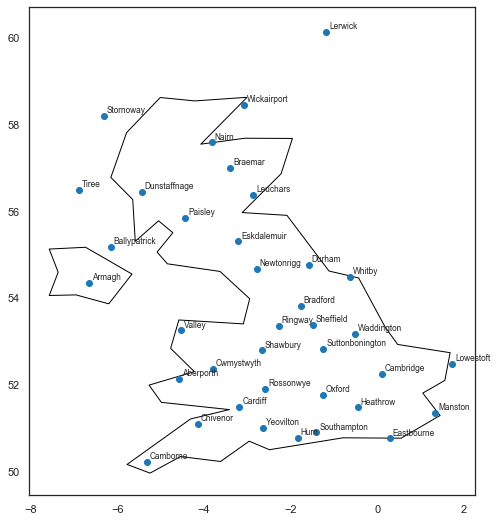

In [10]:
# Create a temporary DataFrame for the plot then delete it later
_stations_map_data = pd.DataFrame({"station": stations_df.station.unique(), "cluster": 0})

# Plot the map
plotMap(_stations_map_data, hide_legend=True)

# Delete the temporary DataFrame
del(_stations_map_data)

### Display a summary of the stations DataFrame

In [11]:
stations_df.describe()

yyyy            mm          tmax          tmin            af  \
count  37539.000000  37539.000000  36712.000000  36738.000000  35318.000000   
mean    1969.044434      6.492634     12.732736      5.929759      3.499405   
std       36.707652      3.454008      5.037526      4.059957      5.192578   
min     1853.000000      1.000000     -0.900000     -8.600000      0.000000   
25%     1949.000000      3.000000      8.500000      2.700000      0.000000   
50%     1976.000000      6.000000     12.400000      5.500000      1.000000   
75%     1997.000000      9.000000     16.800000      9.400000      6.000000   
max     2020.000000     12.000000     28.300000     17.000000     31.000000   

               rain           sun  
count  36768.000000  29050.000000  
mean      73.004050    118.427095  
std       48.296324     63.144891  
min        0.000000      2.800000  
25%       39.200000     64.700000  
50%       62.600000    111.900000  
75%       94.900000    163.700000  
max      568.800000    350.300000

### Check the date of the newest weather station and the date when a station was retired (if any)

In [12]:
stations_min_max_dates = stations_df[["station", "date"]].groupby(by="station", as_index=False).agg(["min", "max"])
stations_min_max_dates.columns = ["Start Date", "End Date"]
stations_min_max_dates = stations_min_max_dates.sort_values(by="End Date").reset_index()
stations_min_max_dates[
    (stations_min_max_dates["Start Date"] == stations_min_max_dates["Start Date"].max()) |
    (stations_min_max_dates["End Date"] == stations_min_max_dates["End Date"].min())
]

station Start Date   End Date
0   southampton 1855-01-01 2000-03-01
24     camborne 1978-10-01 2020-03-01

The latest station that was installed was in **1978-10-01 in Camborne**.

In order to have an equal number of observations for every station, it would be useful to ignore the observations recorded before 1978-10-01.

Most of the stations after this date, have data until 2020-03-01 except for three stations so it would be safe to take no action in this regard, even if those stations will have fewer records compared to the rest.

*N.B: In a later part, there is a table that summarises the number of observations by station and by month.*

### Create a disaggregated DataFrame from the original data
This DataFrame excludes the dates when some stations were not installed yet and keeps the data only from the date where all stations became operational. This way, all stations will have a equal number of recorded measurements (observations), except for stations like Ballypatrick and Chivenor that were retired before March 2020.

Add two additional columns to the DataFrame, one with the name of the month corresponding to each observation and another one with the Average Temperature (calculation of $\frac{Tmax + Tmin}{2}$ )



In [13]:
# Check the correlation between the different variables excluding all measurments recorded
# before 1978 when the last station was installed in Camborne. After 1978 all the stations 
# in this analysis have recorded measurments.
stations_of_interest = stations_df.loc[stations_df.yyyy > 1978].copy()

# Put the full name of the month in the table
stations_of_interest["month"] = stations_of_interest.date.dt.month_name()

# Create a calculated field for the average temperature
stations_of_interest["tavg"] = (stations_of_interest["tmax"] + stations_of_interest["tmin"]) / 2

# Summarise the table
stations_of_interest.describe()

yyyy            mm          tmax          tmin            af  \
count  17739.000000  17739.000000  17599.000000  17597.000000  17556.000000   
mean    1998.767913      6.472518     13.050611      6.248463      3.308385   
std       11.843631      3.459602      5.005863      4.091842      5.026766   
min     1979.000000      1.000000     -0.300000     -8.100000      0.000000   
25%     1989.000000      3.000000      8.900000      3.000000      0.000000   
50%     1999.000000      6.000000     12.600000      5.800000      0.000000   
75%     2009.000000      9.000000     17.100000      9.800000      5.000000   
max     2020.000000     12.000000     28.300000     17.000000     28.000000   

               rain           sun          tavg  
count  17596.000000  14603.000000  17585.000000  
mean      76.646823    120.471013      9.649849  
std       52.167533     63.005385      4.481891  
min        0.000000      4.000000     -3.650000  
25%       40.100000     67.300000      6.000000  
50%       64.900000    113.500000      9.150000  
75%       99.100000    166.200000     13.400000  
max      568.800000    350.100000     22.450000

### Check the data types of the DataFrame columns

In [14]:
stations_of_interest.dtypes

station                object
yyyy                    int32
mm                      int32
tmax                  float64
tmin                  float64
af                    float64
rain                  float64
sun                   float64
provisional           boolean
date           datetime64[ns]
month                  object
tavg                  float64
dtype: object

### Check which columns have a large number of Null values (missing data)

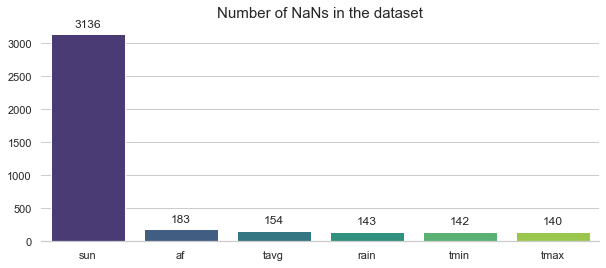

In [15]:
# Check how many NAs there are 
_na_df = stations_of_interest.isna().sum().sort_values(ascending=False)
_na_df = _na_df[_na_df > 0]
if len(_na_df) > 0:
    sns.set_style("whitegrid")
    _, _ax = plt.subplots(figsize=(10, 4))
    sns.barplot(x=_na_df.index.values, y=_na_df.values, palette="viridis", ax=_ax)
    _ax.set_title("Number of NaNs in the dataset", fontsize=15)
    _ax.set_ylim(0)
    for p in _ax.patches:
        _ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
    sns.despine(left=True, top=True, ax=_ax)

The variable "sun" has the largest number null values (approximately 17% of the dataset).\
Being so large, we will have to decide eventually if the entire column should be removed or only the observations where the null values are.\
The decision will be made based on how many data points will remain for each station if we keep the column but only remove the null values. Or instead we remove the whole column and keep more data points (observations) for all the stations.

In the next step we will explore the possibility of dropping the NaN values and see the effect on the dataset.

In [16]:
# Drop the records that have NA values
# stations_of_interest = stations_of_interest.drop(columns="sun").dropna()
stations_of_interest_nan = stations_of_interest.dropna()

In [17]:
# Fix the datatype of the column month to int32
stations_of_interest_nan.mm = stations_of_interest_nan.mm.astype(np.int32)

/Users/jean/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


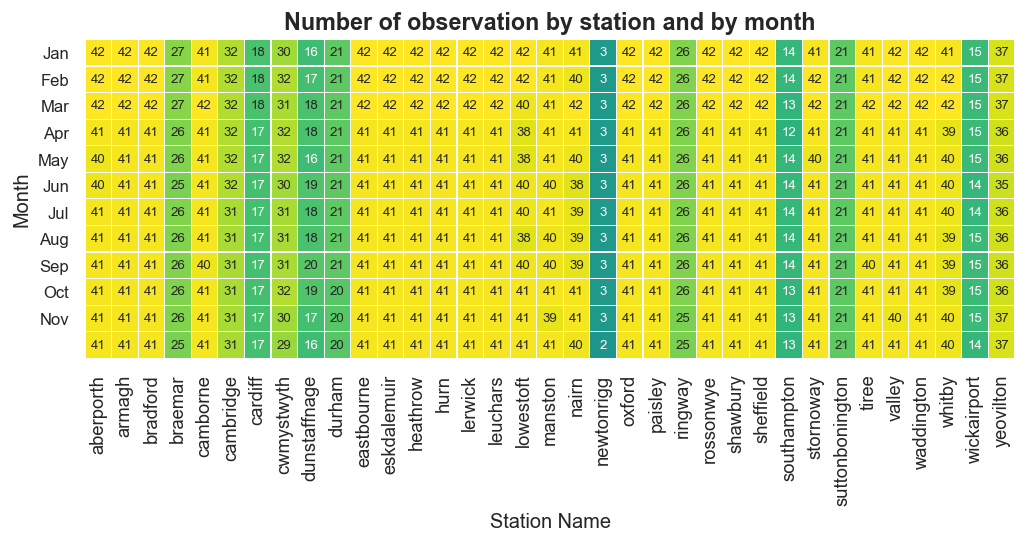

In [18]:
# The number of observations per station per months
stations_of_interest_summary = stations_of_interest_nan.groupby(by=["station", "mm"]).size().unstack()

f, _ax = plt.subplots(figsize=(10,15), dpi=120)
_ax = sns.heatmap(stations_of_interest_summary.T, annot=True, annot_kws={"size": 8}, 
                  linewidths=.1, square=True, cbar=False, 
                  center=0, vmin=0,
                  cmap="viridis", ax=_ax)
_ax.set_ylabel("Month")
_ax.set_yticklabels(calendar.month_abbr[1:12], rotation=0, fontweight='light', fontsize='small')
_ax.set_xlabel("Station Name")
_ = _ax.set_title("Number of observation by station and by month", fontdict={"fontsize": 14, "fontweight": "bold"})

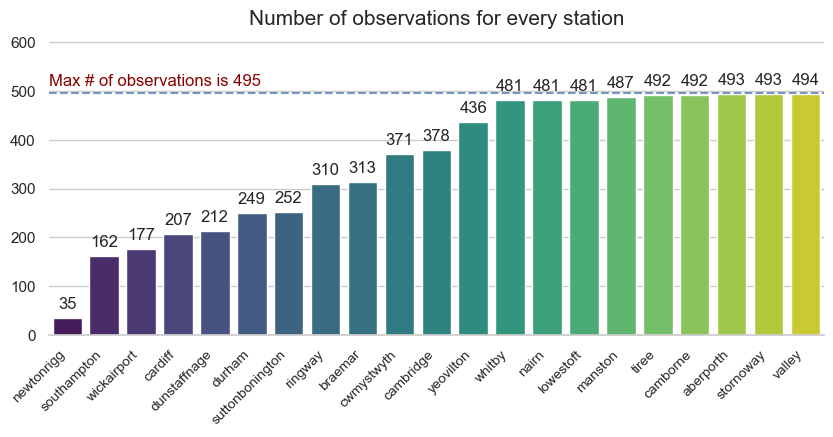

In [19]:
# Show the stations that have the least number of observations.
# The stations that have the highest number of observations will be omitted
_na_df = stations_of_interest_nan.groupby(by=["station"]).size().sort_values(ascending=True)
_na_df_max = int(_na_df.max())
_na_df = _na_df[_na_df < _na_df_max]
if len(_na_df) > 0:
    sns.set_style("whitegrid")
    _, _ax = plt.subplots(figsize=(10, 4), dpi=100)
    
    _ax.axhline(_na_df_max, ls='--', alpha=.75)
    _ax.text(-0.5, _na_df_max + 15, f"Max # of observations is {_na_df_max}", color="darkred")
    
    sns.barplot(x=_na_df.index.values, y=_na_df.values, palette="viridis", ax=_ax)
    _ax.set_title("Number of observations for every station", fontsize=15)
    _ax.set_ylim(0, _na_df_max + _na_df_max * .25)
    _ax.set_xticklabels(_ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='small')

    for p in _ax.patches:
        _ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        
    sns.despine(left=True, top=True, ax=_ax)

The result of dropping the NaNs rendered some stations such as "Newtonrigg" and "Southampton" unusable given the very small number of observations.

We will try in the next steps to drop the column "Sun" the remove the NaNs and observe the effect on the data.

In [20]:
# Drop the column "Sun" then drop the records that have NA values
stations_of_interest_nan = stations_of_interest.drop(columns="sun").dropna()

# Fix the datatype of the column month to int32
stations_of_interest_nan.mm = stations_of_interest_nan.mm.astype(np.int32)

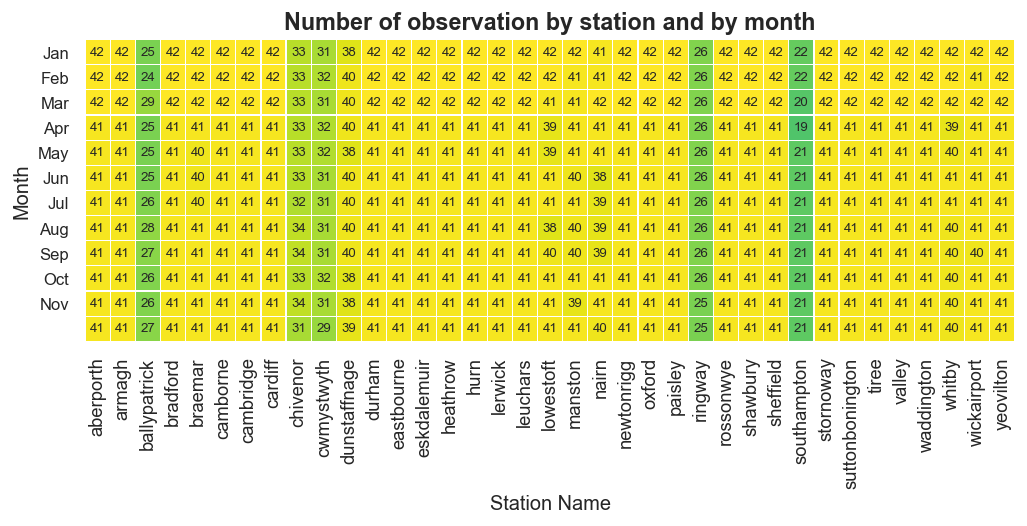

In [21]:
# The number of observations per station per months
stations_of_interest_summary = stations_of_interest_nan.groupby(by=["station", "mm"]).size().unstack()

f, _ax = plt.subplots(figsize=(10,15), dpi=120)
_ax = sns.heatmap(stations_of_interest_summary.T, annot=True, annot_kws={"size": 8}, 
                  linewidths=.1, square=True, cbar=False, 
                  center=0, vmin=0,
                  cmap="viridis", ax=_ax)
_ax.set_ylabel("Month")
_ax.set_yticklabels(calendar.month_abbr[1:12], rotation=0, fontweight='light', fontsize='small')
_ax.set_xlabel("Station Name")
_ = _ax.set_title("Number of observation by station and by month", fontdict={"fontsize": 14, "fontweight": "bold"})

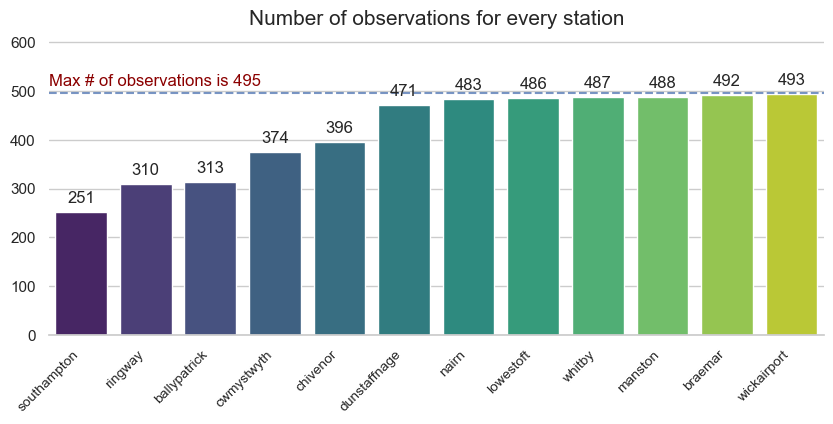

In [22]:
# Show the stations that have the least number of observations.
# The stations that have the highest number of observations will be omitted
_na_df = stations_of_interest_nan.groupby(by=["station"]).size().sort_values(ascending=True)
_na_df_max = int(_na_df.max())
_na_df = _na_df[_na_df < _na_df_max]
if len(_na_df) > 0:
    sns.set_style("whitegrid")
    _, _ax = plt.subplots(figsize=(10, 4), dpi=100)
    
    _ax.axhline(_na_df_max, ls='--', alpha=.75)
    _ax.text(-0.5, _na_df_max + 15, f"Max # of observations is {_na_df_max}", color="darkred")
    
    sns.barplot(x=_na_df.index.values, y=_na_df.values, palette="viridis", ax=_ax)
    _ax.set_title("Number of observations for every station", fontsize=15)
    _ax.set_ylim(0, _na_df_max + _na_df_max * .25)
    _ax.set_xticklabels(_ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='small')

    for p in _ax.patches:
        _ax.annotate(int(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        
    
    sns.despine(left=True, top=True, ax=_ax)

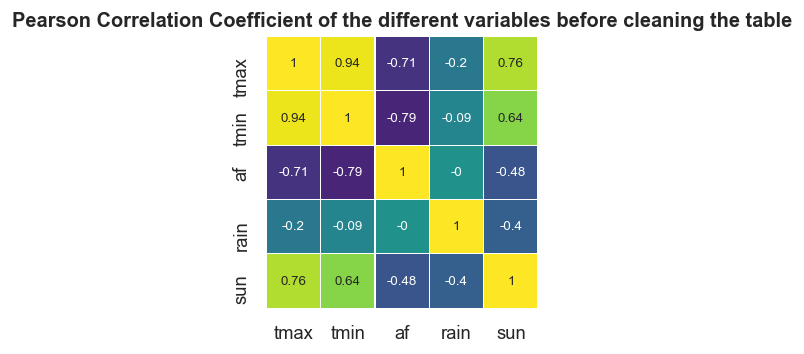

In [23]:
# Check the correlation between the different variables
vars_corr = stations_of_interest[["tmax", "tmin", "af", "rain", "sun"]].corr().round(2)
f, _ax = plt.subplots(figsize=(3,3), dpi=120)
_ax = sns.heatmap(vars_corr, annot=True, annot_kws={"size": 8}, 
                  linewidths=.1, square=True, cbar=False, 
                  center=0, vmin=-1, vmax=1,
                  cmap="viridis", ax=_ax)
_ = _ax.set_title("Pearson Correlation Coefficient of the different variables before cleaning the table", fontdict={"fontsize": 12, "fontweight": "bold"})

Given the above bar chart and the correlation matrix, it would be more appropriate to drop the column "Sun" entirely then attempt to remove the empty values as this method, unlike the previous one, keeps much more data for every station.

The variable "sun" is also relatively correlated with tmax and tmin so it should not have a serious effect later on, on the clustering and the classification.

In [24]:
# Drop the column "Sun" then drop the records that have NA values
stations_of_interest = stations_of_interest.drop(columns="sun").dropna()

# Fix the datatype of the column month to int32
stations_of_interest.mm = stations_of_interest.mm.astype(np.int32)

### Plot the correlation between the different variables after the data cleaning

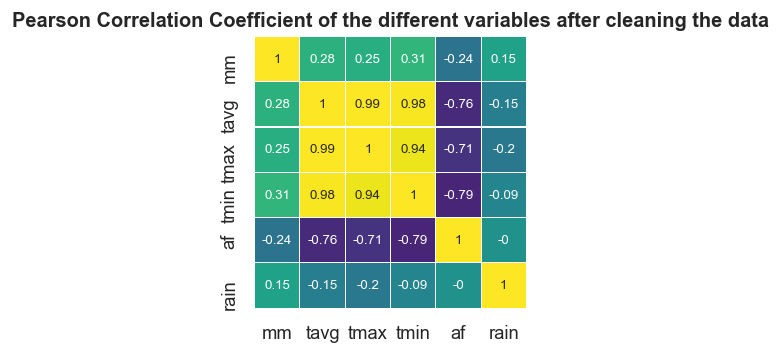

In [25]:
# Check the correlation between the different variables
vars_corr = stations_of_interest[["mm", "tavg", "tmax", "tmin", "af", "rain"]].corr().round(2)
f, _ax = plt.subplots(figsize=(3,3), dpi=120)
_ax = sns.heatmap(vars_corr, annot=True, annot_kws={"size": 8}, 
                  linewidths=.1, square=True, cbar=False, 
                  center=0, vmin=-1, vmax=1,
                  cmap="viridis", ax=_ax)
_ = _ax.set_title("Pearson Correlation Coefficient of the different variables after cleaning the data", fontdict={"fontsize": 12, "fontweight": "bold"})

### Display a summary of the number of observations available for each station by month 

### **Plot the minimum and maximum temperatures by month for every station**
The boxplots show the distribution of the temperature data for each station and for each month. The plots also show if there are any outliers, how the data is distributed, how similir or dissimilar the distributions are, if there are any visible patterns or not, etc.

<Figure size 3600x2400 with 0 Axes>

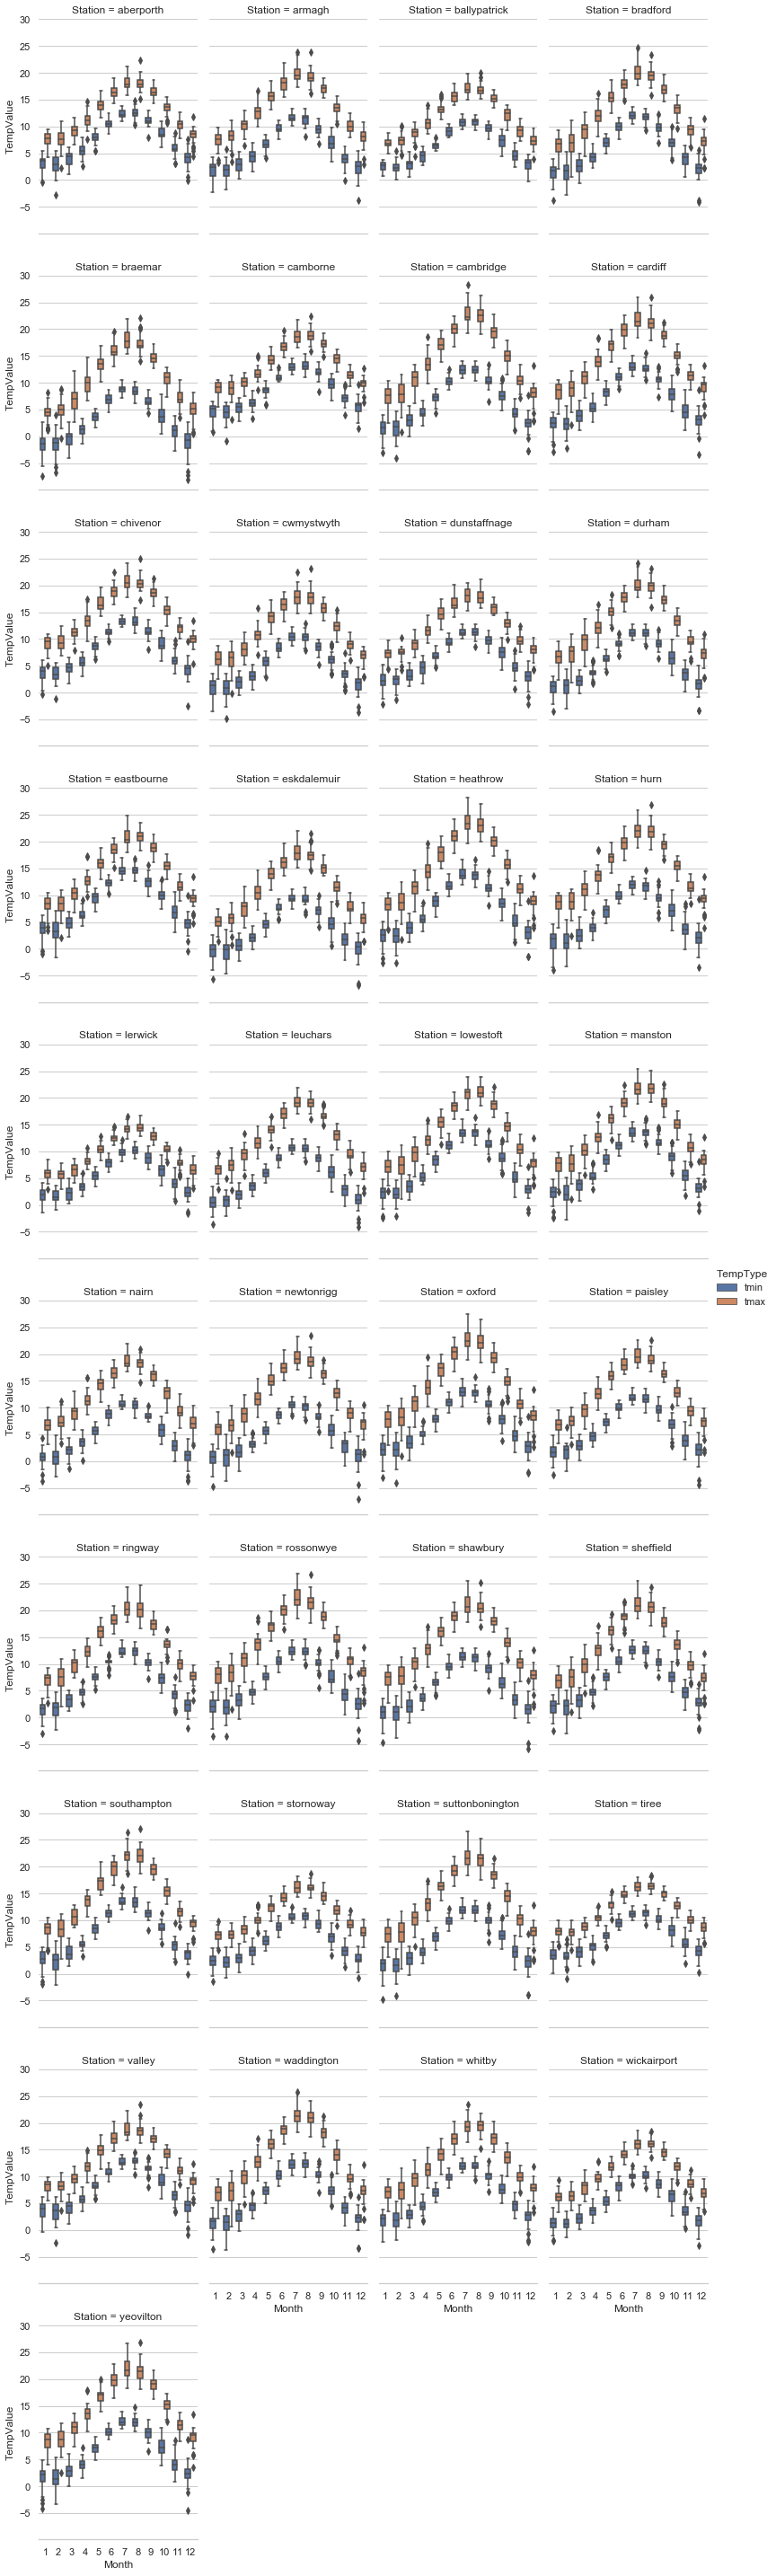

In [26]:
s0_df = stations_of_interest.loc[:, ["station", "mm", "tmin", "tmax"]]
s0_df = s0_df.set_index(["station", "mm"]).stack().reset_index()
s0_df.columns=["Station", "Month", "TempType", "TempValue"]

plt.figure(dpi=600)
ax = sns.catplot(x="Month", y="TempValue", hue="TempType", col="Station",
                data=s0_df, kind="box",
                height=4, aspect=.7, col_wrap=4)
_ = ax.despine(left=True)

### **Visual inspection and preliminary assumptions**
A quick visual inspection of the above boxplots puts on view some interesting findings:
- Stations such as Lerwick are clearly in areas colder than stations like Oxford. This becomes obvious when looking at the maximum temperatures over the entire year and seeing that temperatures in Lerwick ar much lower than Oxford.
- Stations like Tiree have much lower fluctuation in tempretures (between minimum and maximum temperatures) compared to Cambridge and Braemar
- The difference between the coldest and the warmest month is less extreme in Ballypatrick compared to Heathrow

The above findings should be exploited by the clustering algorithm to identify similarities, however, it is worth mentioning that as a first thought, the disrimination between the different station will not be an easy job because most of them seem to share very similar characteristics that will make it hard for the algrothm to differentiate between them.

### **Removing the outliers from the data**
To be able to identify the outliers, we have to look at the data for each station and for each month separately. This is because every station in every month have a unique distribution of minimum and maximum temperatures that are lower or higher that other stations in the same month. The same goes for the other variables such as the rain, sun and air frost.

If we analyse these variables as one single set, a very low temperature recorded for a station might appear as an outlier in the entire distribution even though this temperature is genuine at the location where it was recorded.

However if we look at each station and each month individually, only temperatures that are so extreme and that are recorded either in rare situations or as a result of a measurement error will be considered as outliers and will be removed only for that specific station at that specific month.

The method used to remove the outliers is the Interquartile Range (IQR).  The interquartile range is a statistical measure that measures the dispersion of the data by calculating the difference between 75th and 25th percentiles IQR = Q3 − Q1. The outliers are determined based on the IQR multiplied by a factor above and blow which, any value is considered an outlier.

References:
- *[Ways to detect and remove outliers](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba)*


In [27]:
# removing outliers using IQR
outlier_df_cols = ["mm", "tmin", "tmax", "af", "rain"]

# Proportion of the IQR past the low and high quartiles to consider as safe values. 
# Points outside this range will be identified as outliers.
qfactor = 1.5

# The copy of the DataFrame in which data with the removed outliers will be stored. 
stations_of_interest_corrected = stations_of_interest.copy()
# stations_of_interest_corrected = stations_of_interest

# Store the number of outliers by station by month here
outliers_numbers = {}

# Loop over every station
for station in stations_of_interest_corrected.station.unique():
#     echo(f"Outlier detection for station {station}:")
    outliers_numbers[station] = {}
    
    # Select the columns that should be reviewed and set the month as the index
    outlier_df = stations_of_interest_corrected.loc[stations_of_interest_corrected.station.str.match(station), outlier_df_cols].set_index("mm")
    # calculate the 25th percentile of the current station for each month
    outlier_25_percentile_df = outlier_df.groupby("mm").agg(lambda a: np.quantile(a, q=.25))
    # calculate the 75th percentile of the current station for each month
    outlier_75_percentile_df = outlier_df.groupby("mm").agg(lambda a: np.quantile(a, q=.75))
    # calculate the IQR of the current station for each month
    outlier_iqr_df = outlier_df.groupby("mm").agg(lambda a: sc.stats.iqr(a, rng=(25, 75), axis=0))

    # Remove the outliers for each month
    # outlier_df.index.unique().astype(np.int32) was placed instead of range(1,13) just in case a specific
    # had no more observations after data cleanup. So this way we prevent potential errors 
    for month in outlier_df.index.unique().astype(np.int32):
        outlier_df_1 = outlier_df.loc[month]
        # Create the filter the values smaller than (25 percentile - 1.5 x IQR) or greater than (75th percentile + 1.5 x IQR)
        outliers_filter = (outlier_df_1 < (outlier_25_percentile_df.loc[month] - qfactor * outlier_iqr_df.loc[month])) | (outlier_df_1 > (outlier_75_percentile_df.loc[month] + qfactor * outlier_iqr_df.loc[month]))
#         outlier_df_1 = outlier_df_1.mask(outliers_filter).fillna(outlier_df_1.mean(axis=0))

        # Compute the number of outliers found
        nb_of_outliers = outlier_df_1.mask(outliers_filter).isna().sum(axis=1).sum(axis=0)
        # Store the number of outliers in the dictionary
        outliers_numbers[station][month] = nb_of_outliers
        
        # Remove the outliers by replacing it with the month's average
        outlier_df_1 = outlier_df_1.mask(outliers_filter, other=outlier_df_1.mean(axis=0), axis=1)
        outlier_df.loc[month] = outlier_df_1
        
#     echo(f"\t{outliers_numbers[station]}")

    stations_of_interest_corrected.loc[stations_of_interest_corrected.station.str.match(station), outlier_df_cols] = outlier_df.reset_index().values

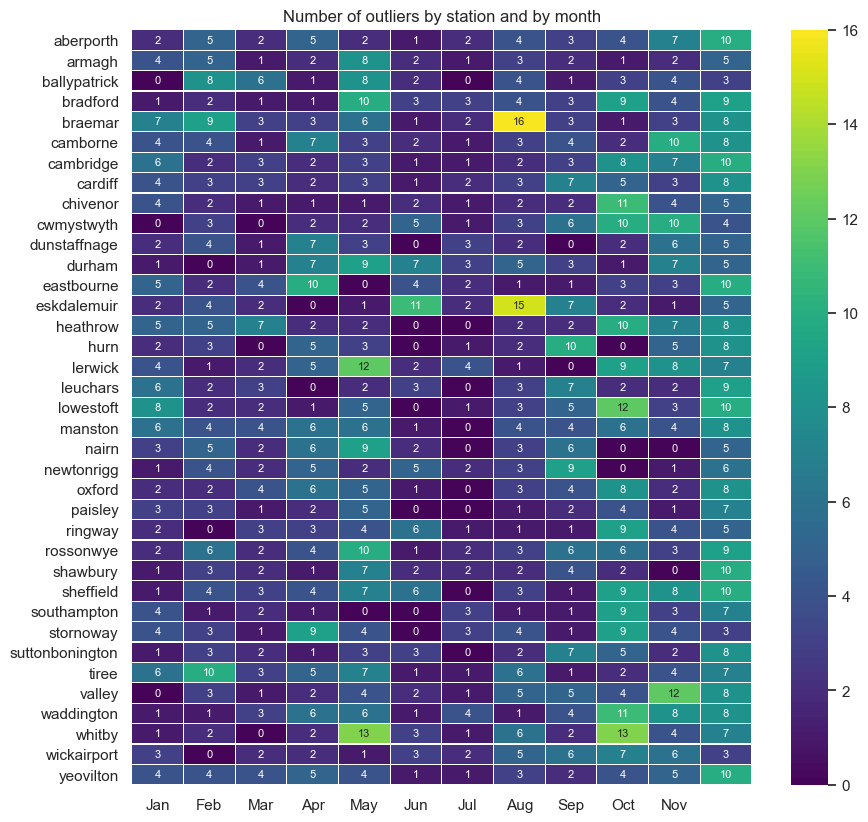

In [28]:
outliers_numbers_df = pd.DataFrame(index=outliers_numbers.keys(), data=outliers_numbers.values())
columns = calendar.month_abbr[1:12]
cmap = sns.color_palette("viridis", 100)
f, ax = plt.subplots(figsize=(10,10), dpi=100)
sns.heatmap(outliers_numbers_df, square=False, annot=True, annot_kws={"size": 8}, fmt="d", linewidths=.1, cmap=cmap, ax=ax)
ax.set_xticklabels(columns)
_ = ax.set_title("Number of outliers by station and by month")

### **Re-Plot the minimum and maximum temperatures by month for every station after removing the outliers**

In [29]:
stations_of_interest = stations_of_interest_corrected
stations_of_interest.mm = stations_of_interest.mm.astype(np.int32)
# stations_of_interest.head()

<Figure size 3600x2400 with 0 Axes>

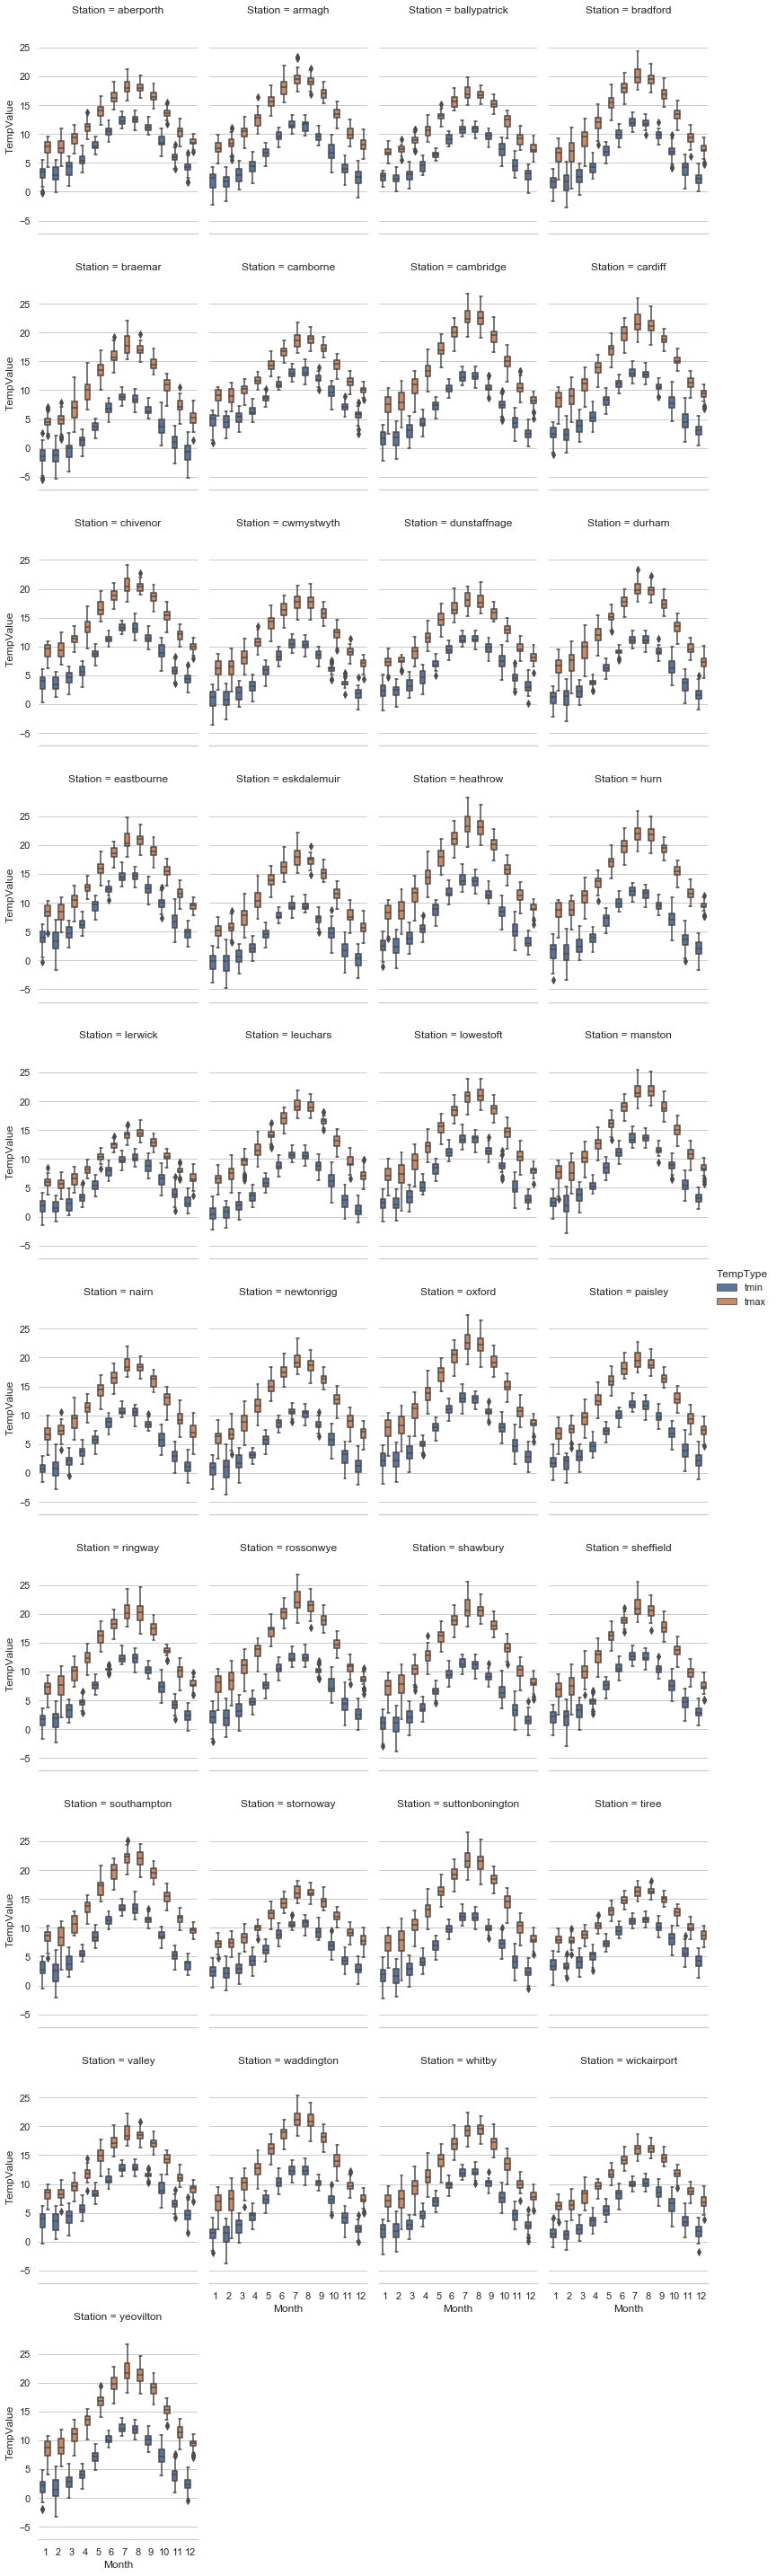

In [30]:
s0_df = stations_of_interest_corrected.loc[:, ["station", "mm", "tmin", "tmax"]]
s0_df = s0_df.set_index(["station", "mm"]).stack().reset_index()
s0_df.columns=["Station", "Month", "TempType", "TempValue"]

plt.figure(dpi=600)
ax = sns.catplot(x="Month", y="TempValue", hue="TempType", col="Station", data=s0_df, kind="box", height=4, aspect=.7, col_wrap=4, legend=True)
_ = ax.despine(left=True)

### Draw a scatter plot between the different variables
The scatter plot is important to illustrate correlations and patterns in data.\
Also, dividing the months into 4 (based on seasons) with a different color for each season, helps in visually segregating the different data points.

In [31]:
# for the sake of visualisation and clarity, add the season of the year to the table and display the 
# plot with a different color for each season (each 3 months)
season_month_tuples = list(zip(['Winter']*3 + ['Spring']*3 + ['Summer']*3 + ['Fall']*3, calendar.month_abbr[1:]))
stations_of_interest["season"] = stations_of_interest["mm"].map(lambda month: season_month_tuples[int(month)-1][0])

<Figure size 3000x3000 with 0 Axes>

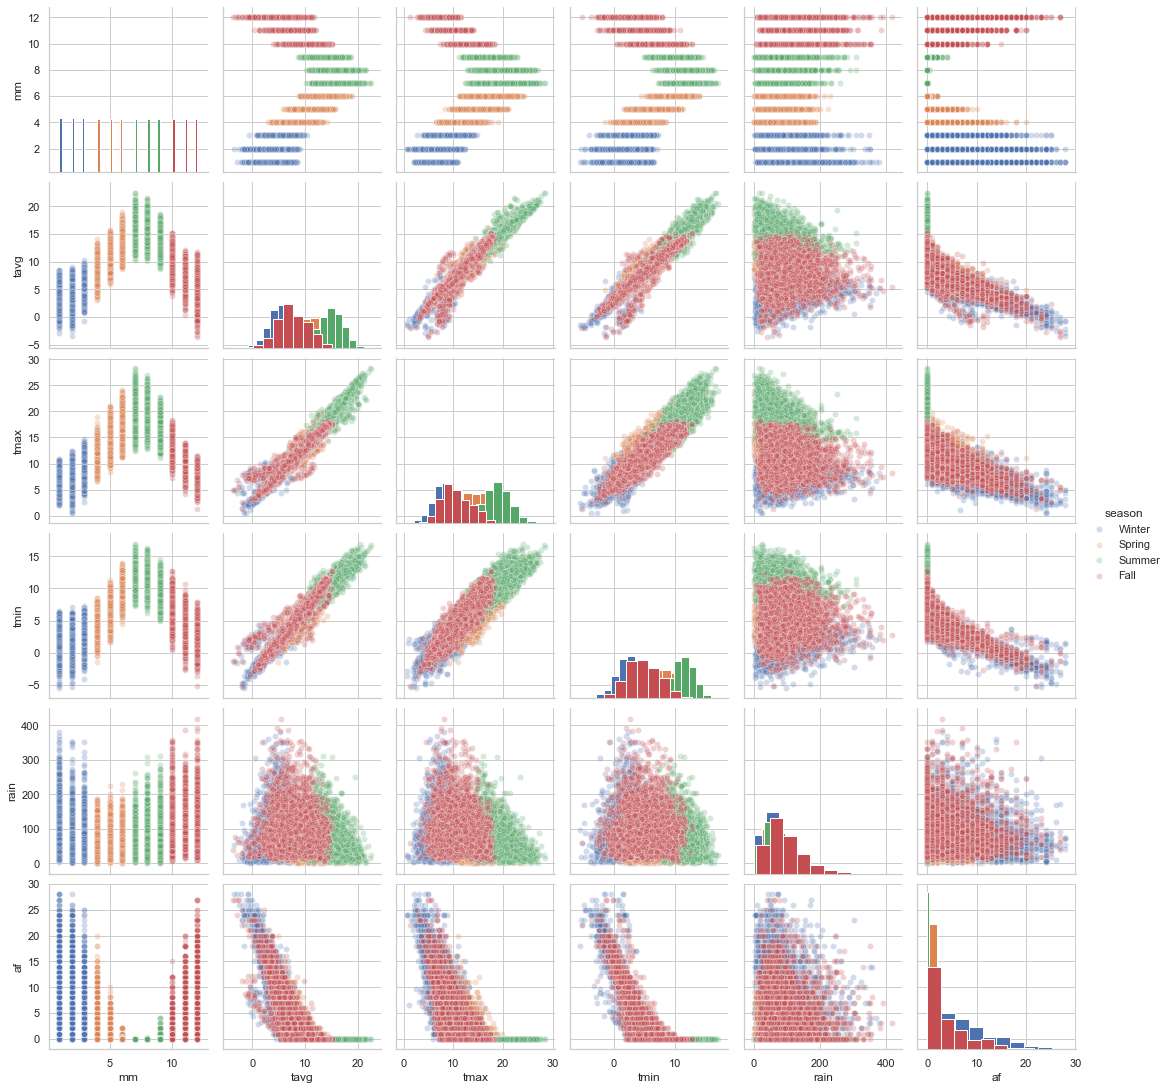

In [32]:
f = plt.figure(figsize=(10, 10), dpi=300)
_ax = sns.pairplot(stations_of_interest, vars=["mm", "tavg", "tmax", "tmin", "rain", "af"],
             diag_kind="hist", hue="season", plot_kws={"alpha": 0.25})

In [33]:
print(f"The dataset contains: {stations_of_interest.shape[0]} observations.")
print(f"The number of stations is: {len(stations_of_interest.station.unique())}.")
print(f"The number of years is: {len(stations_of_interest.yyyy.unique())}.")

The dataset contains: 17419 observations.
The number of stations is: 37.
The number of years is: 42.


## Part 1: Clustering
In the previous part, data was gathered, filtered and cleaned. However the values in the data were left intact whereby no scaling or normalisation were applied in order to keep the dataset as generic as possible and be able to use it in later sections.

For the clustering part, few decisions have to made before we start:
- We need to select the columns (the variables) that will be used as input variables for the clustering algorithm.
- Choose our clustering algorithm (clustering technique)
- Choose how our data will be aggregated and how many samples will be used from the dataset to fit the clustering model
- Rescale our data to avoid bias towards larger variables
- Decide into how many clusters do we need to devide our data

#### Part 1 - A: Clustering using the entire subset of data
In this part, the entire subset of data that was selected in the previous section will be used to perform the clustering.\
Individual observations from each station for each month will be clustered differently, therefore, we will need to find a way to decide in which cluster the station will be finally placed. To solve this issue, I decided to count how many times, observations from a station were places in each cluster, and finally choose the cluster that has the largest number of observations.

The dataset contains 17419 observations and approximately 40 observation for every month for each station, except for a few stations that have less. The number of observations should be enough for the clustering algorithm to detect similarities between different stations.

If we look back at the box plots of the stations' temperatures, we notice that having a yearly average without disaggregation by month would flatten the data a lot and the station would loose a lot of its characteristics. An important aspect of these characteristics is how the temperature changes from one month to the next, how higher or lower the max and minimum temperatures become (less dispersion) or how close they remain (more dispersion, flatter curve). The variability of the temperature during the same month is equally important as a characteristic of a station.

The initial choice of the number of clusters that I made is 5. The choice is based on intuition only with the expectation of being able to differentiate between the northern, southern, eastern, western and central stations.

The first attempt to cluster the stations will be done using **agglomerative clustering** and using different combination of **input variables** and **linkage** types.

The input variable will be rescaled using the **RobustScaler**. This step is crucial because the agglomerative clustering algorithm combines variables via a Euclidean distance function so the  contribution of an input will depend heavily on its variability relative to other inputs. In our case, having the *rain* variable with values between 0 and 400 compared to *tmin* with values between -5 and 17 will give more importance to the contribution of the *rain* variable.



In [34]:
# The variables that will be used as inputs for the clustering
input_col_names = ["mm", "tmin", "tmax", "af", "rain"]

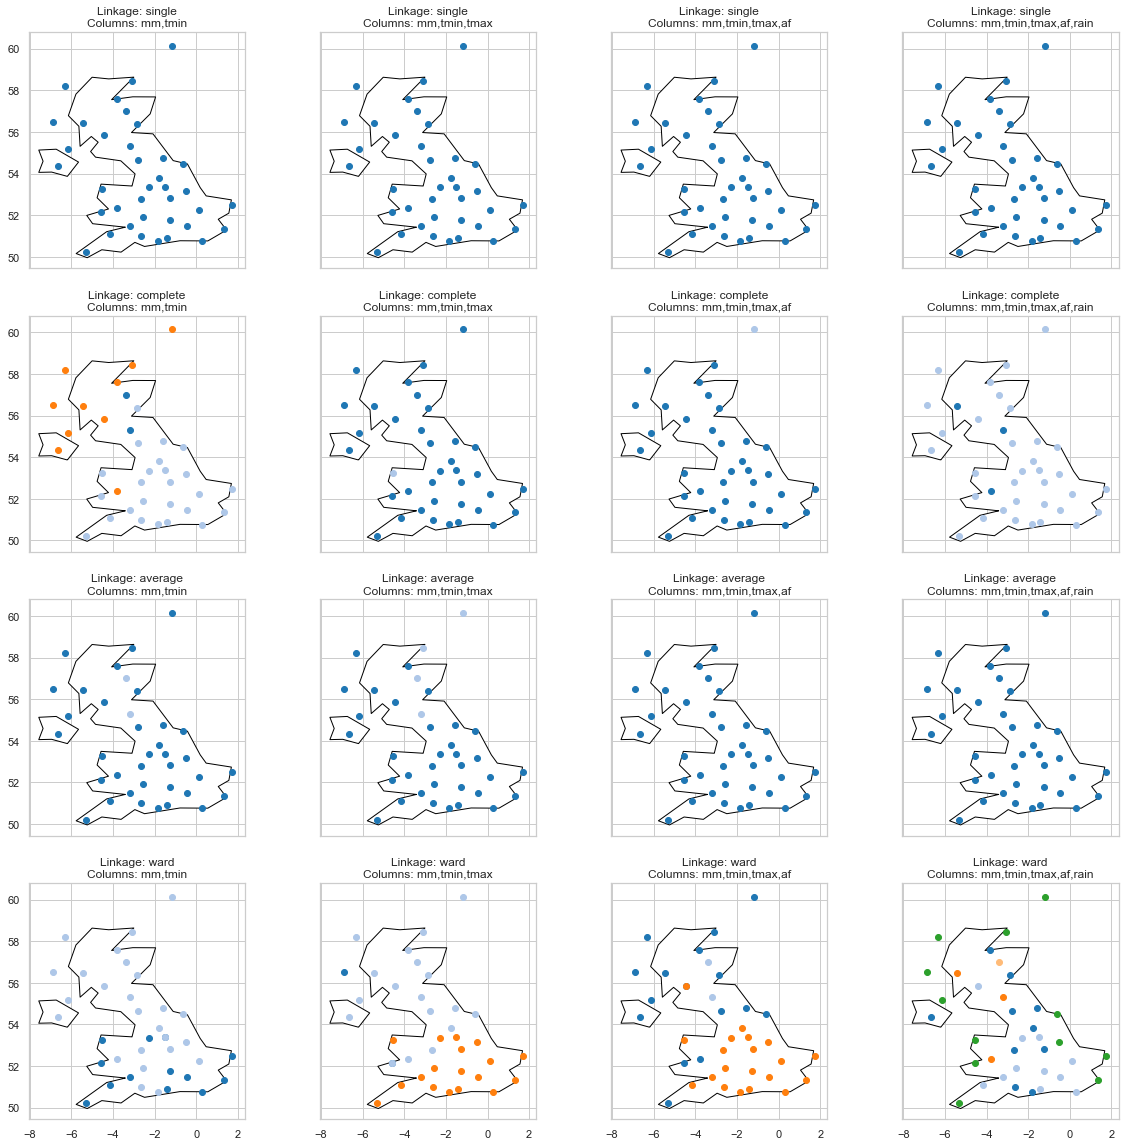

In [35]:
n_clusters = 5
linkage = ["single", "complete", "average", "ward"]

n_rows = len(linkage)
n_cols = len(input_col_names) - 1
cols = [input_col_names[:n] for n in range(2, len(input_col_names)+1)]

col_linkage_tuples = list(itertools.product(linkage, cols))

# The exact name of the variable should be Scaling Method
# Perform data scaling to prevent clustering bias due to variability in values
NormalisationMethod = RobustScaler()
ClusteringMethod = AgglomerativeClustering

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, sharey=True, figsize=(20,20))

for i, ax_n in enumerate(ax.reshape(-1)):
    linkage_n = col_linkage_tuples[i][0]
    cols_n = col_linkage_tuples[i][1]

    # The main training data
    X_train = stations_of_interest.loc[:, cols_n]
    X_train = NormalisationMethod.fit_transform(X_train)

    clustering = ClusteringMethod(linkage=linkage_n, n_clusters=n_clusters).fit(X_train)
    stations_of_interest["cluster"] = clustering.labels_

    plotSingleMap(stations_of_interest, ax=ax_n, hide_legend=True, show_station_names=False)
    ax_n.set_title(f"Linkage: {linkage_n}\nColumns: {','.join(cols_n)}")


The graphs in the above plot show that the only linkage criteria that was able to perform well on our dataset and merge clusters together fairly without forming one cluster that extend across the entire map  is the *ward* linkage.\
We also notice that introducing additional variables (diemsions) using the *ward* linkage enabled the algorithm to identify additional clusters even if the clusters seem to be noisy.\
Finally the last finding is that the high number of number of clusters initially chose is very optimistic and there are two main clusters that are prevailing most of the time even though the target is 5.

To address the issue of clustering and noise, adding connectivity constraints for the agglomerative clustering algorithm can forbid the merging of stations that are not adjacent by creating a connectivity matrix that defines the neighboring samples for each sample.\*

This option will be explored in the next graph by varying the number of cluster and the number of adjacent neighbors chose when creating the connectivity constraints.

Reference:
[Adding connectivity constraints](https://scikit-learn.org/stable/modules/clustering.html#adding-connectivity-constraints)

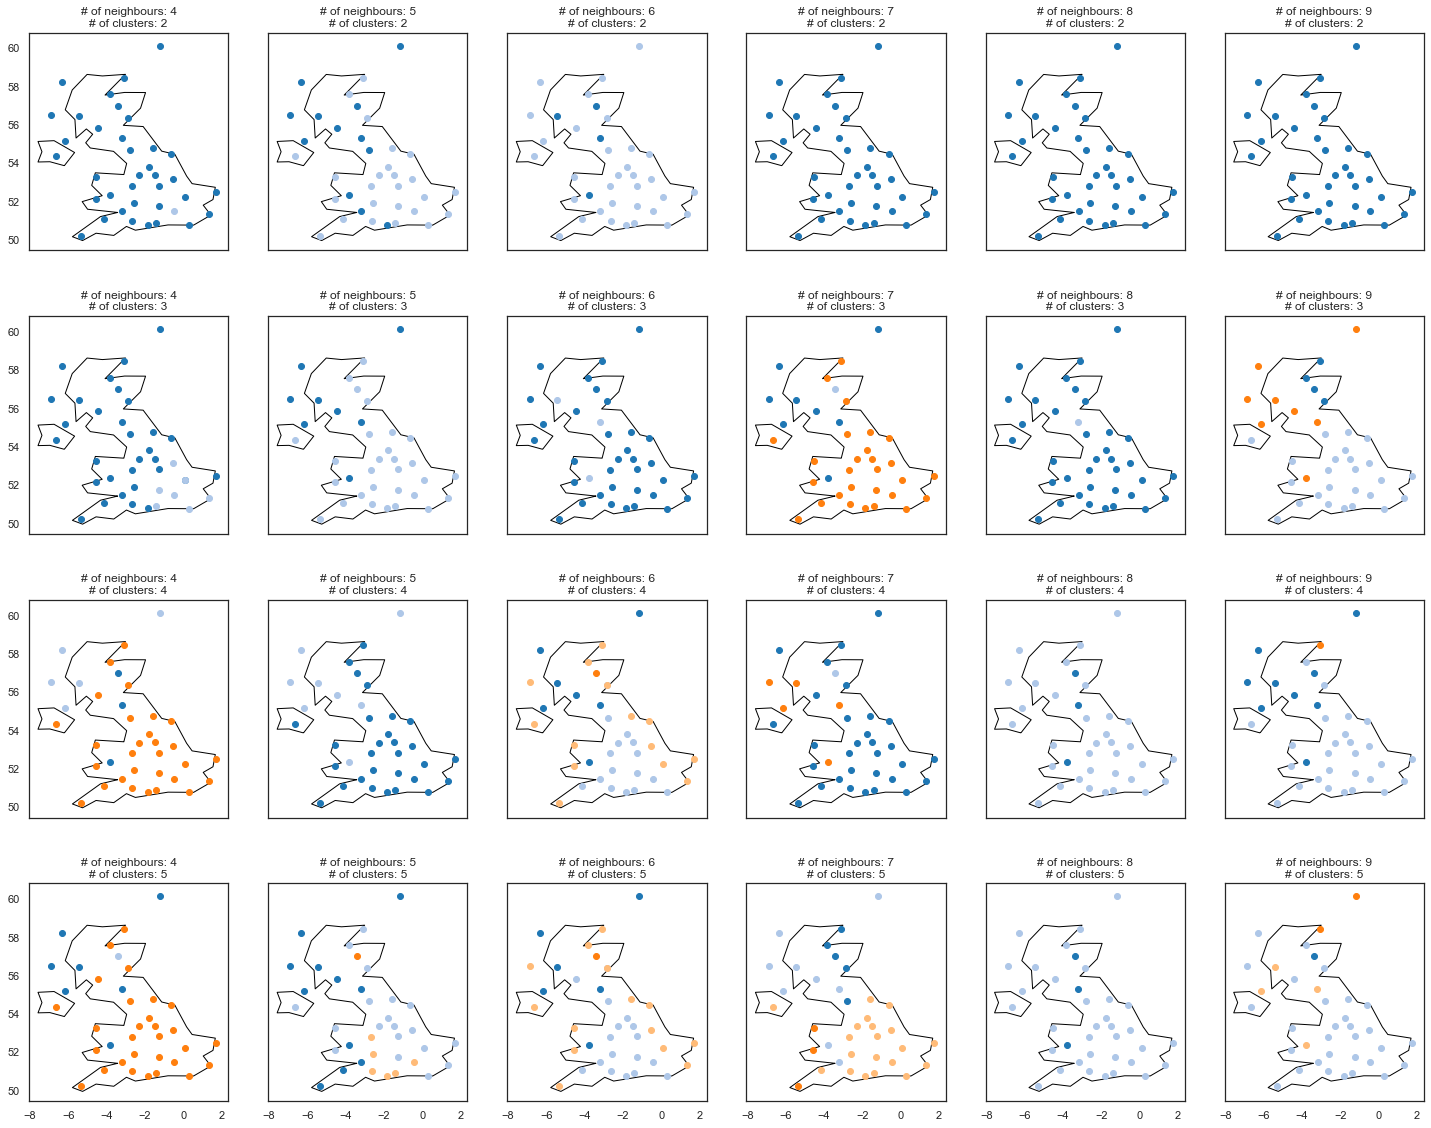

In [36]:
clusters = range(2, 6) # The number of clusters
neighbours = range(4, 10) # The number of neighbours

linkage = "ward"

n_rows = len(clusters)
n_cols = len(neighbours)

clusters_neighbours_tuples = list(itertools.product(clusters, neighbours))

# Perform data scaling to prevent clustering bias due to variability in values
ScalingMethod = RobustScaler()
ClusteringMethod = AgglomerativeClustering

# The main training data
X_train = stations_of_interest.loc[:, input_col_names]
X_train = NormalisationMethod.fit_transform(X_train)
    
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, sharey=True, figsize=(25,20))

for i, ax_n in enumerate(ax.reshape(-1)):
    
    clusters_n = clusters_neighbours_tuples[i][0]
    neighbours_n = clusters_neighbours_tuples[i][1]
    
    # Create the connectivity constraint
    kn_connections = kneighbors_graph(X_train, n_neighbors=neighbours_n)
    
    # Create and fit the clustering model
    clustering = ClusteringMethod(linkage=linkage, n_clusters=clusters_n, connectivity=kn_connections).fit(X_train)
    stations_of_interest["cluster"] = clustering.labels_
    
    # Plot the map with the clustered stations
    plotSingleMap(stations_of_interest, ax=ax_n, hide_legend=True, show_station_names=False)
    ax_n.set_title(f"# of neighbours: {neighbours_n}\n# of clusters: {clusters_n}")

The first insight that we can notice from the above graph is that the apparently strong similarity in the data between the east coast stations and the stations between the centre and the southern coast.

Another observation is that the higher the number of clusters we are choosing the better the segregation is becoming between the stations.

The most logical selection in this case is:
- 5 neighbours, 4 clusters
- 6 neighbours, 4 clusters
- 7 neighbours, 5 clusters

To help supporting our choice, we will use an alternative clustering algorithm and check if we will be able to confirm or reject our assumptions.

### Part 1 - B: Trying an alternative method to clustering using the Fuzzy C-Means Method

Fuzzy clustering unlike standard clustering, generates for every observation a set of coefficients that indicate the degree of correspondence to a given cluster. Thus each observation can be a member in one or more clusters. This approach is called soft clustering compared to the hard clustering approaches such as the K-Means that produce partitions in which each observation belongs to only one cluster.

To be able to use the *Fuzzy C-Means* algorithm, we will need to perform dimensionality reduction for our input variables to transform the input matrix to a two-dimensional matrix. This step will be accomplished using the **Principal component analysis (PCA)** algorithm. "*Kernel PCA uses a kernel function to project the dataset into a higher-dimensional space, where it is linearly separable.*"


References:
- This clustering method was inspired by the article [Fuzzy c-means clustering](https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html#prediction)
- Additional reading regarding the use of kernels was done on [Scikit-Learn's website](https://scikit-learn.org/stable/modules/decomposition.html#kernel-pca)
- [Introduction to Kernel PCA](https://www.geeksforgeeks.org/ml-introduction-to-kernel-pca/)

In [37]:
# use Kernel PCA to reduce the dimensions of of the dataset to two
gamma = 20
kpca = KernelPCA(kernel="rbf", n_components=2, fit_inverse_transform=False, gamma=gamma)

# The main training data
X_train = stations_of_interest.loc[:, input_col_names]
X_train = NormalisationMethod.fit_transform(X_train)

# Fit the kernel PCA with the multi-dimensional data
X_kpca = kpca.fit_transform(X_train)

# Store the two-dimensional output of the Kernel PCA
xpts = X_kpca[:,0]
ypts = X_kpca[:,1]

/Users/jean/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/sklearn/utils/extmath.py:530: RuntimeWarning: invalid value encountered in multiply
  v *= signs[:, np.newaxis]


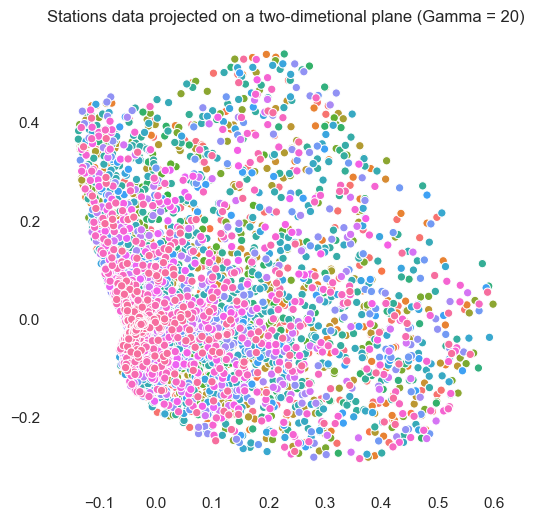

In [38]:
# Plot the output of the PCA
sns.set_style("white")
_, _ax = plt.subplots(figsize=(6,6), dpi=100)
_ax = sns.scatterplot(xpts, ypts, cmap="Blues", ax=_ax, hue=stations_of_interest.station.values, legend=False)
_ax.set_title(f"Stations data projected on a two-dimetional plane (Gamma = {gamma})")
sns.despine(left=True, bottom=True)

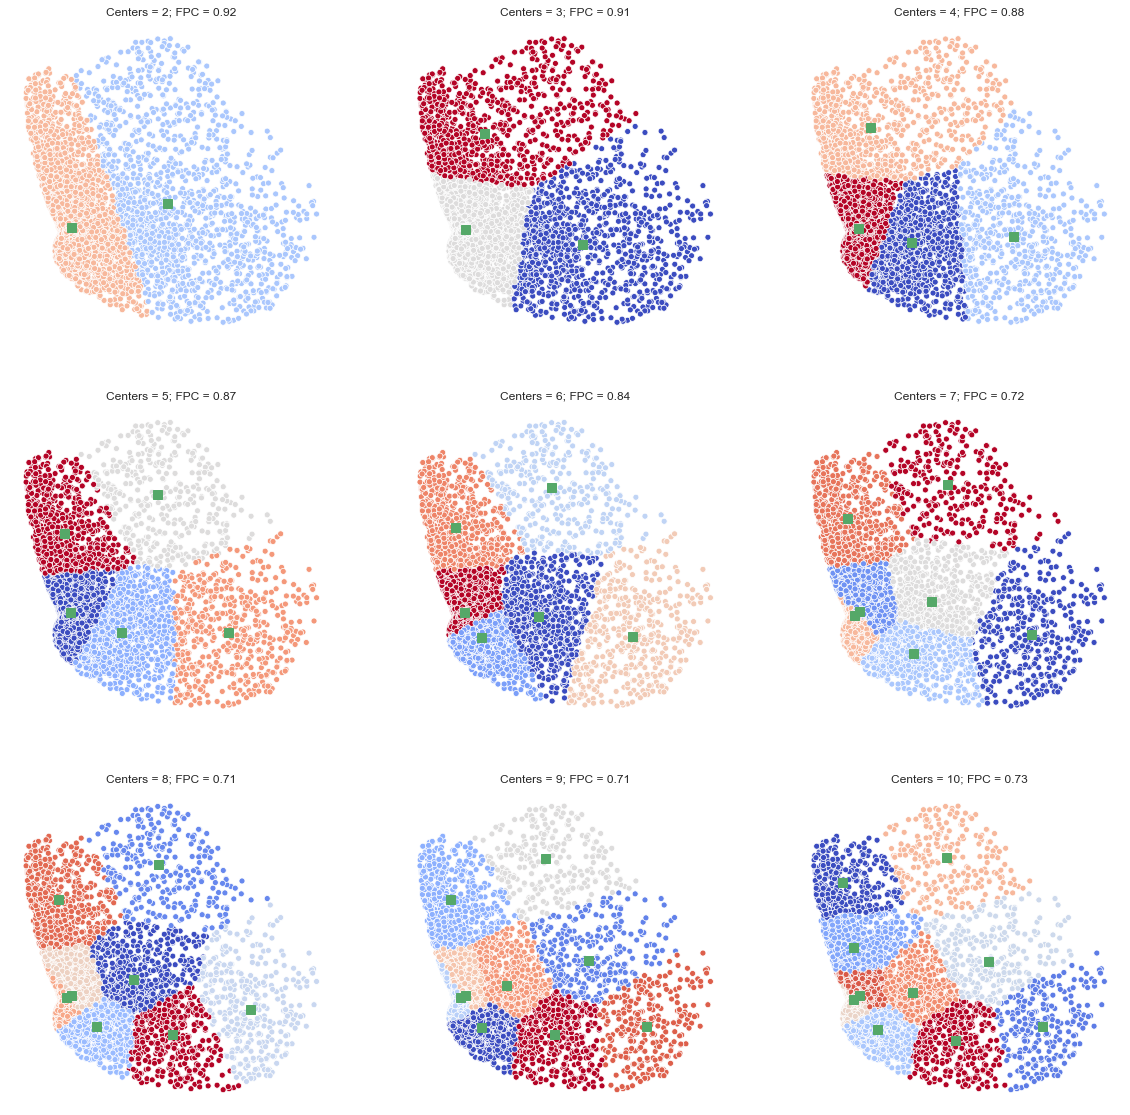

In [39]:
# fuzz.cluster.cmeans() documentation:
# cntr: 2d array, size (S, c) | Cluster centers.  Data for each center along each feature provided for every cluster (of the `c` requested clusters).
# u: 2d array, (S, N) | Final fuzzy c-partitioned matrix.
# u0: 2d array, (S, N) | Initial guess at fuzzy c-partitioned matrix (either provided init or random guess used if init was not provided).
# d: 2d array, (S, N) | Final Euclidian distance matrix.
# jm: 1d array, length P | Objective function history.
# p: int | Number of iterations run.
# fpc: float | Final fuzzy partition coefficient.

# The number of clusters to try using the Fuzzy C-Means
n_clusters = range(2,11)

# The fuzzy partition coefficient for each iteration
fpcs = []

    
fig, ax = plt.subplots(ncols=3, nrows=math.ceil(len(n_clusters)/3), sharex=False, sharey=False, figsize=(20, 20))

for i, ax_n in enumerate(ax.reshape(-1)):
    if i > len(n_clusters) - 1:
        ax_n.axis('off')
        break;
        
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(X_kpca.T, n_clusters[i], 2, error=0.005, maxiter=1000, init=None)

    fpcs.append(fpc)

    # For each data point in training set, get the cluster in which it has the
    # maximum likelihood to be in
    cluster_membership = np.argmax(u, axis=0)
    
    _data = pd.DataFrame({"x": xpts, "y": ypts, "c": cluster_membership})
    sns.scatterplot(data=_data, x="x", y="y", hue="c", ax=ax_n, palette="coolwarm", legend=False)

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax_n.plot(pt[0], pt[1], 'gs', markersize=9)

    ax_n.set_title('Centers = {0}; FPC = {1:.2f}'.format(n_clusters[i], fpc))
    ax_n.axis('off')

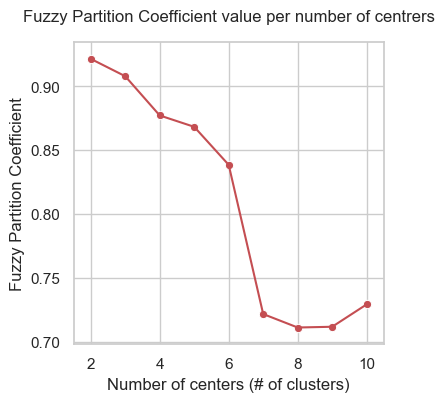

In [40]:
# Plot the FPC value for each number of clusters
sns.set_style("whitegrid")
fig = plt.figure(figsize=(4, 4), dpi=100)

_data = pd.DataFrame({"n_centers": list(n_clusters), "fpc": fpcs})
ax = sns.lineplot(data=_data, x="n_centers", y="fpc", color="r", markers=True, dashes=True)
sns.scatterplot(data=_data, x="n_centers", y="fpc", color="r", ax=ax)
ax.set_xlabel("Number of centers (# of clusters)")
ax.set_ylabel("Fuzzy Partition Coefficient")
ax.set_title("Fuzzy Partition Coefficient value per number of centrers", pad=15)
del(_data)

The fuzzy C-Means clustering shows that the weather data can clearly be divided into two clusters which is the optimal number of clusters given the value of the Fuzzy Partition Coefficient (FPC). Nevertheless, having between 2 and 6 clusters is also an option as the FPC remains relatively high, then it drops drastically beyond 6 clusters. 

K-Means is another famous alternative to agglomerative clustering and it works by calculating the distance between each data-point and its neighbours, then try to separate the data-points by minimising the *inertia* which is within-cluster sum-of-squares to identify clusters.

Inertia being the sum of squared distances of samples to their closest cluster centre, as the number of clusters increase, the value of inertia decreases. Therefore we need to find the smallest value of inertia that has the smallest number of clusters. ie. to choose the best number of clusters in tradeoff for a larger inertia.

To be able make this decision, we will fit a KMeans model 9 times with a different number of clusters at each time and see look at the **Elbow Plot** to see what it can tell us in addition to the insights that we gathered from the previous steps.

Quoting the Scikit-Learn website:
> Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-means clustering can alleviate this problem and speed up the computations.

As a way to overcome the issue of dimentionality, we previously used PCA for the Fuzzy C-Means algorithm, so we will use the same transformed data to fit the K-Means side by side with non-transformed multidimentional data. 

References:
- [K-Means - Scikit-Learn.org](https://scikit-learn.org/stable/modules/clustering.html#k-means)

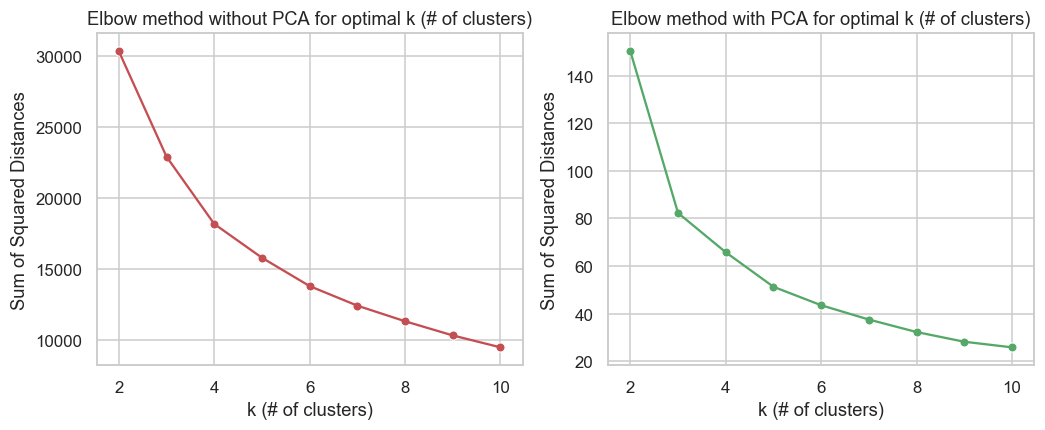

In [41]:
# Plot the Sum of Squared Distances for each number of clusters
sns.set_style("whitegrid")
_, (ax, ax2) = plt.subplots(1, 2, figsize=(11, 4), dpi=110)

# The Sum of Squared Distances for each clustering attempt
sum_of_squared_distances = []

# The main training data
X_train = stations_of_interest.loc[:, input_col_names]
X_train = NormalisationMethod.fit_transform(X_train)

# The number of clusters to try with the K-Means algorithm
k_clusters = range(2,11)

# Calculate the inertia for the multi-dimentional dataset
for k in k_clusters:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_train)
    sum_of_squared_distances.append(k_means.inertia_)

# Plot the plot, and talk the talk
sns.lineplot(x=n_clusters, y=sum_of_squared_distances, color="r", markers=True, dashes=True, ax=ax)
sns.scatterplot(x=n_clusters, y=sum_of_squared_distances, color="r", ax=ax)
ax.set_xlabel('k (# of clusters)')
ax.set_ylabel('Sum of Squared Distances')
_ = ax.set_title('Elbow method without PCA for optimal k (# of clusters)')

# Clear the old values to store the new arrivals from our KMeans, PCA & co store
sum_of_squared_distances.clear()

# Calculate the inertia for the two-dimensional dataset after PCA
for k in k_clusters:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(X_kpca)
    sum_of_squared_distances.append(k_means.inertia_)

# Plot the elbow plot
sns.lineplot(x=n_clusters, y=sum_of_squared_distances, color="g", markers=True, dashes=True, ax=ax2)
sns.scatterplot(x=n_clusters, y=sum_of_squared_distances, color="g", ax=ax2)
ax2.set_xlabel('k (# of clusters)')
ax2.set_ylabel('Sum of Squared Distances')
_ = ax2.set_title('Elbow method with PCA for optimal k (# of clusters)')

The K-Means elbow plots confirms our previous assumption about the optimal number of clusters and narrows down our choices to 2 or 3 clusters.

Going back to the agglomerative clustering let's plot our final map.

(<Figure size 576x720 with 1 Axes>,
 None)

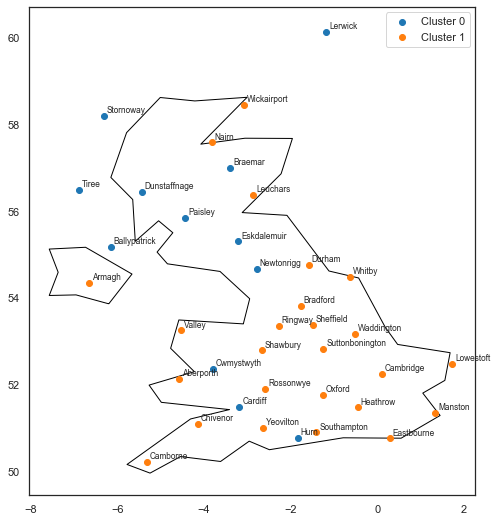

In [42]:
sns.set_style("white")

n_neighbours = 5
n_clusters = 2
# The main training data
X_train = stations_of_interest.loc[:, input_col_names]
X_train = NormalisationMethod.fit_transform(X_train)

# Create the connectivity constraint
kn_connections = kneighbors_graph(X_train, n_neighbors=n_neighbours)

# Create and fit the clustering model
clustering = ClusteringMethod(linkage=linkage, n_clusters=n_clusters, connectivity=kn_connections).fit(X_train)
stations_of_interest["cluster"] = clustering.labels_

# Plot the map with the clustered stations
plotMap(stations_of_interest)

### Part 1 - C: Conclusion
Having tried different algorithms and a multitude of configurations for each of them, the conclusions that we can come out with are as follows:
- The clustering algorithms did well at clustering individual observations from each station, but when combined together to create clusters of stations, most of the time there was one dominant cluster which means that the data that we have does not have enough variability to segregate the stations accordingly.
- In most of our trials, two major clusters were recurrently appearing and this fact was justified later on by the elbow plot. This indicates that stations in the east and center have different characteristics from stations in the north-west.

#### Possible improvement:
One of the options worth exploring is a multi-pass clustering by which we make the first clustering of all the observations, then we aggregate the data with the identified clusters and cluster it again.\
Another way to improve the clustering is by combining additional data from other sources, or introducing additional dimensions that would improve the relationship between observations from the same station and observations from nearby stations.

### Part 1 - D: Off the record experimentation
In this part, some additional experimentation have been conducted with aggregated datasets that have much less observations that the original dattaset used in the previous sections.

The purpose of this part was to explore the effect of the sample size on clustering and to make a side-by-side comparision between different algorithms and different dataset sizes.

In [43]:
# Create a DataFrame with stations data aggregated by year
X_yearly = stations_of_interest[["station", "yyyy", "mm", "tmin", "tmax", "rain", "af"]]
X_yearly = X_yearly.groupby(by=["station", "yyyy"])

X_yearly_df = X_yearly["tmin"].agg("min").reset_index()
X_yearly_df["tmax"] = X_yearly["tmax"].agg("max").values
X_yearly_df["rain"] = X_yearly["rain"].agg("sum").values
X_yearly_df["af"] = X_yearly["af"].agg("sum").values
X_yearly_df.head()

station  yyyy  tmin  tmax        rain         af
0  aberporth  1979   0.3  17.6  975.600000  37.000000
1  aberporth  1980   1.0  17.7  827.300000  18.000000
2  aberporth  1981   1.1  18.4  748.714344  17.487805
3  aberporth  1982   2.5  17.9  917.600000  17.000000
4  aberporth  1983   0.5  20.7  821.700000  17.731707

In [44]:
# check if there's any NaNs
X_yearly_df[X_yearly_df.iloc[:, 2:].isna().sum(axis=1) > 0]

Empty DataFrame
Columns: [station, yyyy, tmin, tmax, rain, af]
Index: []

In [45]:
X_yearly_df = X_yearly_df.dropna()

In [46]:
# Create a DataFrame with one reading per station
X_yearly_df_avg = X_yearly_df.groupby("station", as_index=False).mean()
X_yearly_df_avg = X_yearly_df_avg.drop(columns=["yyyy"])
X_yearly_df_avg.head()

station      tmin       tmax         rain          af
0     aberporth  2.269048  18.462427   867.494021   15.151444
1        armagh  0.743424  19.899535   795.319692   36.107074
2  ballypatrick  1.837931  17.013793  1162.101648   16.422708
3      bradford  0.573810  20.215621   845.172424   38.132916
4       braemar -2.735261  18.254762   860.507116  100.436379

In [47]:
input_col_names_agg = input_col_names[1:]

X_train_yearly = X_yearly_df.loc[:, input_col_names_agg]
X_train_yearly = NormalisationMethod.fit_transform(X_train_yearly)

X_train_agg = X_yearly_df_avg.loc[:, input_col_names_agg]
X_train_agg = NormalisationMethod.fit_transform(X_train_agg)

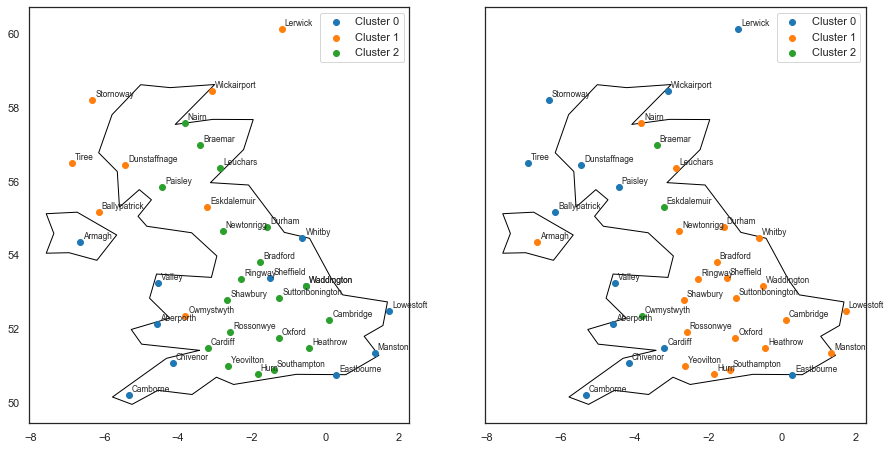

In [48]:
ClusteringMethod = AgglomerativeClustering(linkage="ward", n_clusters=3)

clustering = ClusteringMethod.fit(X_train_yearly)
X_yearly_df["cluster"] = clustering.labels_

clustering = ClusteringMethod.fit(X_train_agg)
X_yearly_df_avg["cluster"] = clustering.labels_

_, ax1, ax2 = plotMap(X_yearly_df, X_yearly_df_avg)

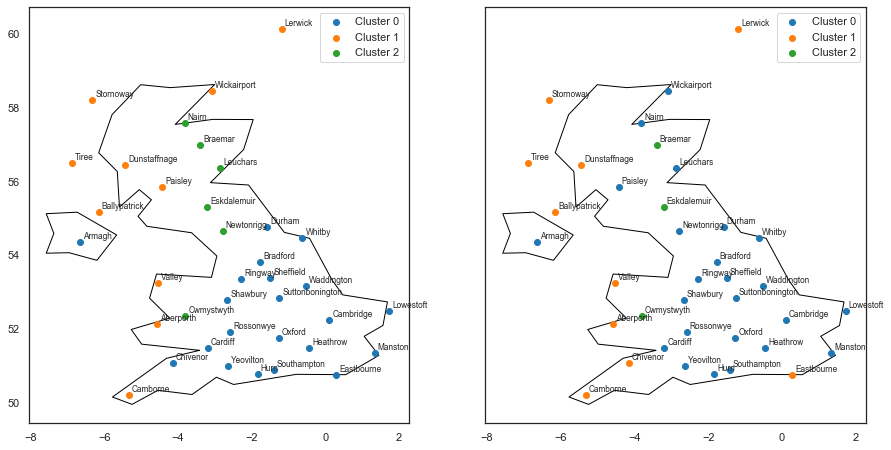

In [49]:
ClusteringMethod = KMeans(n_clusters=3).fit(X_train)

clustering = ClusteringMethod.fit(X_train_yearly)
X_yearly_df["cluster"] = clustering.predict(X_train_yearly)

clustering = ClusteringMethod.fit(X_train_agg)
X_yearly_df_avg["cluster"] = clustering.predict(X_train_agg)

_, ax1, ax2 = plotMap(X_yearly_df, X_yearly_df_avg)

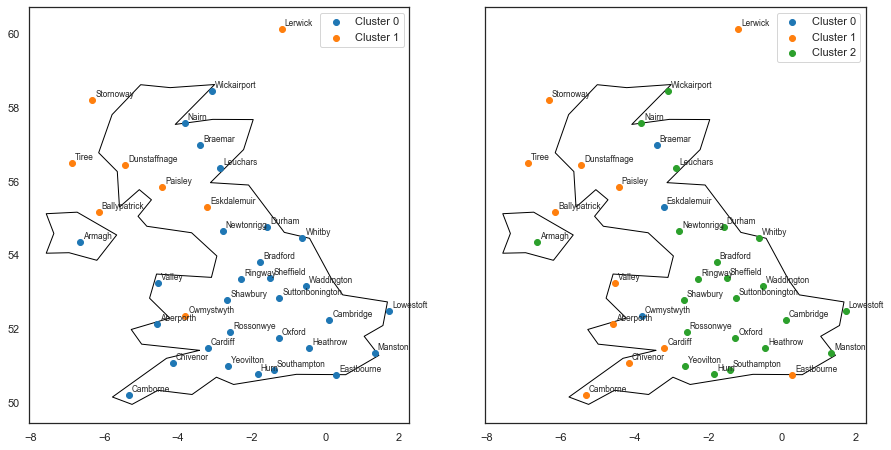

In [50]:
ClusteringMethod = Birch(threshold=0.5, n_clusters=3, branching_factor=50)

clustering = ClusteringMethod.fit(X_train_yearly)
X_yearly_df["cluster"] = clustering.predict(X_train_yearly)

clustering = ClusteringMethod.fit(X_train_agg)
X_yearly_df_avg["cluster"] = clustering.predict(X_train_agg)

_, ax1, ax2 = plotMap(X_yearly_df, X_yearly_df_avg)

Converged after 176 iterations.
Converged after 21 iterations.


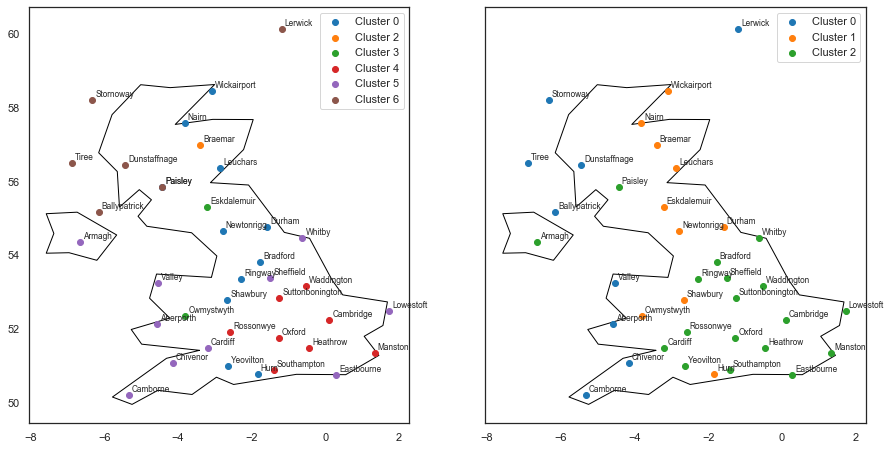

In [51]:
from sklearn.cluster import AffinityPropagation

ClusteringMethod = AffinityPropagation(preference=-155, verbose=True)
ClusteringMethodAgg = AffinityPropagation(preference=-16, verbose=True)

clustering = ClusteringMethod.fit(X_train_yearly)
X_yearly_df["cluster"] = clustering.labels_

clustering_agg = ClusteringMethodAgg.fit(X_train_agg)
X_yearly_df_avg["cluster"] = clustering_agg.labels_

_, ax1, ax2 = plotMap(X_yearly_df, X_yearly_df_avg)

#### Final Words on clustering:
Most of the algorithms used in the last part, performed way better and without much fiddling with their parameters, when the sample was smaller, and they were able to give interesting results with very little observations. (even with one observation per station)

I can fairly say, based on the above, that clustering algorithms suffer from the "curse of sample size", and reducing the sample size by choosing well the aggregation strategy or the sampling strategy can radically improve the results. One way of sampling that I've tried but didn't show in this notebook for brevity, was by using the "Stratified KFold" technique which is used generally for cross-validation. This technique picks the same percentage of random samples from the large dataset, so when used for clustering it turns out to improve the results a lot.

## Part 2: Classification

### Part 2 - A: Combining Weather Data with Stations' Coordinates

The stations' coordinates were read initially in Part 0 when the datasets were fetched. This data will be merged with the main weather stations DataFrame that was used in the previous Part.

First we will exclude 5 stations. The 5 stations that will be excluded are the stations that have the lowest number of observations. A bar graph will be plotted that shows these stations and their respective number of observations.

Once the stations are removed, the stations will be divided based on their latitude into 3 groups: Northern Third, Central Third and Southern Third.

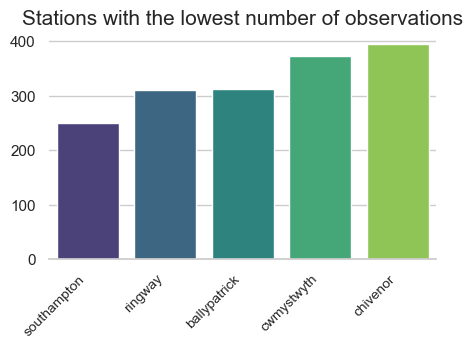

In [52]:
# Merge the weather stations DataFrame with the locations DataFrame
stations_with_loc = stations_of_interest.merge(station_locations, on=["station"], how="left")

# Show the stations that have the least number of observations.
# The stations that have the highest number of observations will be omitted
_lowest_stations_df = stations_with_loc.groupby(by=["station"]).size().sort_values(ascending=True)
_lowest_stations_df = _lowest_stations_df.head(5)

# Plot the stations that have the least number of observations.
sns.set_style("whitegrid")
_, _ax = plt.subplots(figsize=(5, 3), dpi=100)
sns.barplot(x=_lowest_stations_df.index.values, y=_lowest_stations_df.values, palette="viridis", ax=_ax)
_ax.set_title("Stations with the lowest number of observations", fontsize=15)
_ax.set_xticklabels(_ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='small')
sns.despine(left=True, top=True, ax=_ax)

In [53]:
# The list of stations that will be excluded
excluded_stations = _lowest_stations_df.index.values

# Remove the records of the 5 excluded stations
stations_with_loc = stations_with_loc[~stations_with_loc.station.isin(excluded_stations)]

# Clean up
del(_lowest_stations_df)
del(_ax)

In [54]:
# The most northerly point has latitude 60.9
northerly_lat_limit = 60.9

# The most southerly point has latitude 49.9
southerly_lat_limit = 49.9

# Northern Third, Central Third and Southern Third
lat_labels = ["Southern Third", "Central Third", "Northern Third"]

# Generate three intervals that categorises the observations as Northern Third, Central Third and Southern Third
lat_interval = pd.interval_range(start=southerly_lat_limit, end=northerly_lat_limit, periods=3, closed="left")

# Categorise the observations in the table according to the intervals created
stations_lat_intervals = pd.cut(stations_with_loc.lat, bins=lat_interval, include_lowest=True)

# Create a label for the created ranges
stations_lat_intervals_name = stations_lat_intervals.cat.rename_categories(lat_labels)

# Add the created ranges to the DataFrame
stations_with_loc["lat_interval"] = stations_lat_intervals

# Add the created labels to the DataFrame
stations_with_loc["lat_interval_name"] = stations_lat_intervals_name

#### Plot a map based on the 3 divisions

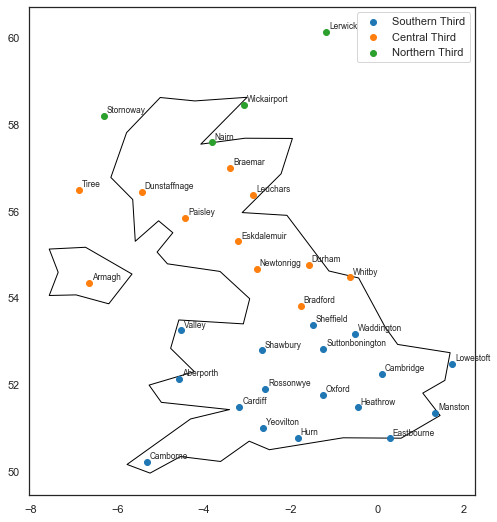

In [55]:
# Set the cluster variable based on the identified categories to plot the map
stations_with_loc.cluster = stations_lat_intervals.cat.codes

sns.set_style("white")
_, _ax, _ = plotMap(stations_with_loc)
_ax.legend(labels=lat_labels)

### Part 2 - B: Preprocessing, Feature Selection & Classification
Most of the preprocessing was conducted in the previous part and consequently the dataset was sanitised and the column *sun* was droped. The same dataset will be used in the comming sections.

The correlation plot shows that *tmin*, *tmax* and *af (air frost)* are strongly correlated with each other. This means that care should be taken when selecting the classification algorithm. For instance, the **Naïve Bayes Classifier** assumes independence between the features which is not the case here. So deciding to choose it as a classifier will require us to drop redundant features.

Alternatively, Tree-based estimators are resilient to correlation and one of their characteristic is that feature selection is embedded in them and they compute feature importances. We will use this characteristic to discard the irrelevant features.

In specific, for our classification, we will use the **Extra Trees Classifier** which is similar to the Random Forests Classifier but with additional randomeness when picking the threshold for the next split.

To avoid overfitting, whereby the model would predict perfectly the samples that it had seen but would fail to predict anything useful on yet-unseen data, we will use **KFold Cross-Validation** instead of the normal **Train-Test Split** and evaluate the resulting scores.

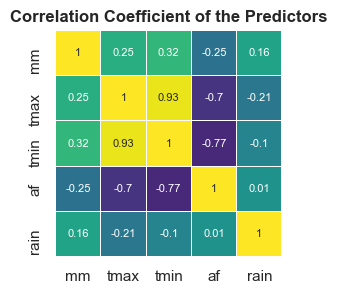

In [56]:
# Check the correlation between the different variables
vars_corr = stations_with_loc[["mm", "tmax", "tmin", "af", "rain"]].corr().round(2)

# Plot the correlations
_, _ax = plt.subplots(figsize=(3,3), dpi=100)
sns.heatmap(vars_corr, annot=True, annot_kws={"size": 8}, 
                  linewidths=.1, square=True, cbar=False, 
                  center=0, vmin=-1, vmax=1,
                  cmap="viridis", ax=_ax)
_ax.set_title("Correlation Coefficient of the Predictors", fontdict={"fontsize": 12, "fontweight": "bold"})

del(vars_corr, _ax)

In [57]:
# The name of the features (predictors)
feature_names = list(input_col_names)

# Predictor variables (Input Variables)
# predictors = RobustScaler().fit_transform(stations_with_loc[input_col_names])
predictors = stations_with_loc[feature_names]

# Labels (Output Variables)
labels = stations_with_loc.lat_interval_name.cat.codes.values.ravel()

In [58]:
# Initialise the Classifier
classifier = ExtraTreesClassifier(n_estimators=1000, max_depth=None, min_samples_split=2)

# Fit the classifier with all the observations to evaluate the Features Importance
classifier.fit(predictors, labels) # This is not the final fit!

# Use the SelectFromModel to estimate the features importance
reduced_classifier = SelectFromModel(classifier, prefit=True)
feature_elimination = reduced_classifier.get_support()

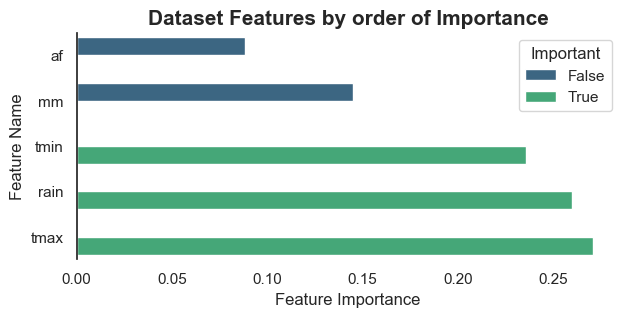

In [59]:
# Plot the feature Importance
sns.set_style("white")
_, _ax = plt.subplots(figsize=(7,3), dpi=100)
_data = pd.DataFrame(data=list(zip(feature_names, classifier.feature_importances_, feature_elimination)), columns=["Feature Name", "Feature Importance", "Important"])
_data = _data.sort_values(by="Feature Importance")
sns.barplot(y="Feature Name", x="Feature Importance", hue="Important", data=_data, palette="viridis", ax=_ax)
sns.despine(left=False, bottom=True)
_ax.set_title("Dataset Features by order of Importance", fontsize=15, fontweight="bold")
del(_ax, _data)

In [60]:
# Re-set the feature names to remove the unimportant features
reduced_feature_names = []
for i, b in enumerate(feature_elimination):
    if b: reduced_feature_names.append(feature_names[i])

# Re-Set the predictors to remove the unimportant features
reduced_predictors = predictors.loc[:, feature_elimination]
# reduced_predictors = predictors[:, feature_elimination]

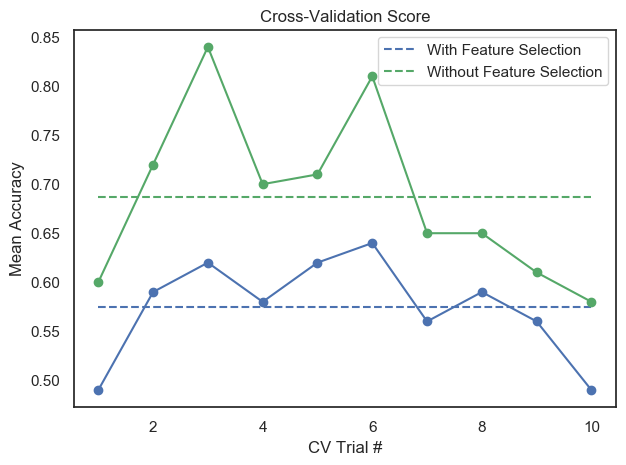

In [61]:
# Re-Initialise the Classifier
classifier = ExtraTreesClassifier(n_estimators=1000, max_depth=None, min_samples_split=15, bootstrap=True)

# Evaluate the reduced classifier using K-Fold Cross Validation
reduced_scores = cross_val_score(classifier, reduced_predictors, labels, cv=10, n_jobs=-1)

scores = cross_val_score(classifier, predictors, labels, cv=10, n_jobs=-1)

# Plot the cross-validation scores
_, _ax = plt.subplots(figsize=(7,5), dpi=100)
_ax.plot(np.arange(1, len(reduced_scores)+1), np.ones(len(reduced_scores))*np.mean(reduced_scores), "b--", label="With Feature Selection")
_ax.plot(np.arange(1, len(reduced_scores)+1), np.round(reduced_scores, 2), "b-o")

_ax.plot(np.arange(1, len(scores)+1), np.ones(len(scores))*np.mean(scores), "g--", label="Without Feature Selection")
_ax.plot(np.arange(1, len(scores)+1), np.round(scores, 2), "g-o")

# _ax.set_ylim(scores.min() - scores.min()*.2, scores.max() + scores.max()*.2)
_ax.set_title(f"Cross-Validation Score")
_ax.set_xlabel("CV Trial #")
_ax.set_ylabel("Mean Accuracy")
_ax.legend(loc='upper right')
del(_ax)


In [62]:
# Reduce the sample size
smaller_sample_years = (stations_with_loc.yyyy.unique())[::5]
smaller_sample_df = stations_with_loc[stations_with_loc.yyyy.isin(smaller_sample_years)]
smaller_sample_predictors = smaller_sample_df[feature_names]
smaller_sample_labels = smaller_sample_df.lat_interval_name.cat.codes.values.ravel()

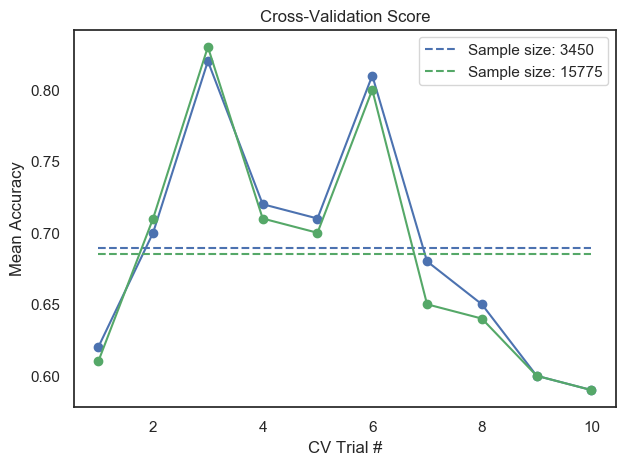

In [63]:
# Re-Initialise the Classifier
classifier = ExtraTreesClassifier(n_estimators=1000, max_depth=None, min_samples_split=7, bootstrap=True)

# Evaluate the reduced classifier using K-Fold Cross Validation
reduced_scores = cross_val_score(classifier, smaller_sample_predictors, smaller_sample_labels, cv=10, n_jobs=-1)

scores = cross_val_score(classifier, predictors, labels, cv=10, n_jobs=-1)

# Plot the cross-validation scores
_, _ax = plt.subplots(figsize=(7,5), dpi=100)
_ax.plot(np.arange(1, len(reduced_scores)+1), np.ones(len(reduced_scores))*np.mean(reduced_scores), "b--", label=f"Sample size: {smaller_sample_predictors.shape[0]}")
_ax.plot(np.arange(1, len(reduced_scores)+1), np.round(reduced_scores, 2), "b-o")

_ax.plot(np.arange(1, len(scores)+1), np.ones(len(scores))*np.mean(scores), "g--", label=f"Sample size: {predictors.shape[0]}")
_ax.plot(np.arange(1, len(scores)+1), np.round(scores, 2), "g-o")

# _ax.set_ylim(scores.min() - scores.min()*.2, scores.max() + scores.max()*.2)
_ax.set_title(f"Cross-Validation Score")
_ax.set_xlabel("CV Trial #")
_ax.set_ylabel("Mean Accuracy")
_ax.legend(loc='upper right')
del(_ax)



Based on the first experiment with ExtraTreesClassifier it seems that the average accuracy score is 67%, fluctuating between 60% and 80% without feature selection. When we apply feature selection and drop the least important features based on the result of the classifier's feature importance property, It seems that the average accuracy score drops to 55% while our expectation was that it should increase.

Another interesting discovery was that reducing the sample size from 15775 to 3450 by choosing observations with a distance of 5 years between them an the next readings, had very insignificant effect on the accuracy of the model.

Tuning the Classifier's parameters *n_estimators* and *min_samples_split* had very minimal effect on the accuracy score. In the next step, we will use RandomizedSearchCV, the brother of GridSearchCV. It's a more randomised grid search model with a parameter for the maximum number of searches and it is less brute force. This class will find the best hyper-parameters for the optimal accuracy score and then fit our model to become ready for a final prediction.

### Part 2 - C: Train the Model
For this part, we will fit the model and plot the confusion matrix. Instead of using train-test split, we will use a randomised grid search cross validation class to search for the best parameters and fit the model. Afterwards, we will predict the labels and plot the confusion matrix and a map with the result of our classification.

In [64]:
# run randomized search
classifier = ExtraTreesClassifier(max_depth=None, bootstrap=True)

params = {"criterion": ["entropy", "gini"],
         "n_estimators": [100, 500, 1500],
         "min_samples_split": [5, 15],
         "max_features": [None, "sqrt", "log2"]}

random_search = RandomizedSearchCV(classifier, param_distributions=params, n_iter=10, cv=10, n_jobs=-1)

random_search.fit(predictors, labels)
labels_pred = random_search.predict(predictors)

conf_matrix = confusion_matrix(labels, labels_pred)
cv_results = pd.DataFrame(random_search.cv_results_)

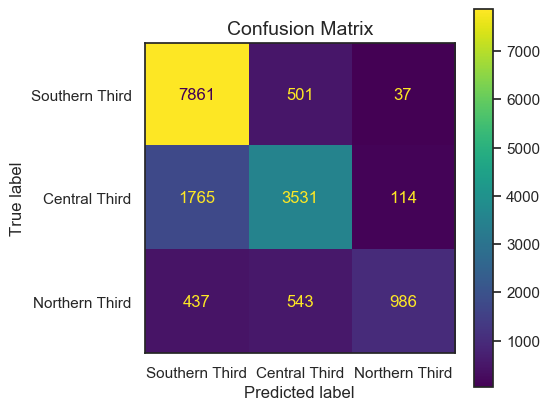

In [65]:
_, _ax = plt.subplots(figsize=(5,5), dpi=100)
plot_confusion_matrix(random_search, predictors, labels, normalize=None, display_labels=lat_labels, values_format="d", ax=_ax)
_ = _ax.set_title("Confusion Matrix", fontsize=14)

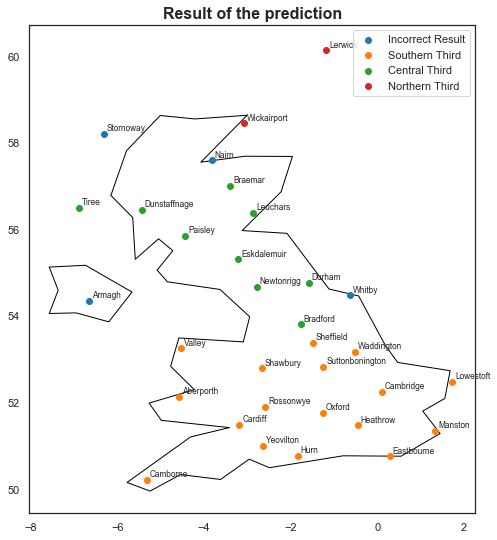

In [66]:
# Set the cluster variable based on the identified categories to plot the map
stations_with_loc.cluster = labels_pred
stations_with_loc.loc[stations_with_loc.cluster != stations_lat_intervals.cat.codes, "cluster"] = -1

# Create a dictionnary of latitude intervals labels
plot_labels = dict(zip(range(-1,3),["Incorrect Result", *lat_labels]))

sns.set_style("white")
_, _ax, _ = plotMap(stations_with_loc, cluster_labels=plot_labels)
_ = _ax.set_title("Result of the prediction", fontsize=16, fontweight="bold")

### Part 2 - D: Conclusion
With an accuracy of approximately 70%, we can see that the model was able to correctly predict 28 of the 32 stations (88% of the stations). The confusion matrix shows that the accuracy is very high for the southern third, then decreases for the central third and becomes close to 50% for the southern third. A 50% accuracy is a very bad accuracy for a classifier because there's a 50-50 chance that a station is correctly labeled.

The obvious reason for the low accuracy in the central and northern third is the lower number of stations available which means less training data for the model.

For such imbalanced datasets, there exists solutions that can improve the final outcome. Among these solutions is selecting equal number of observations for each label when fitting the model. Chaining classifiers can also be another way by which three classifiers are trained with binary labels for each class using a Logistic Regression model or any single-class classifier.

Finally it is fair to say that a weather station's location in the UK can be determined with a reasonable accuracy based on weather data.

## Part 3: Weather and Happiness
In this section, we will start by downloading automatically the dataset from the ONS website. If the dataset is already downloaded it will be read into a Pandas DataFrame. The original dataset is not analysis friendly so we will have to remove the unnecessary part and keep only the relevant columns.

The *Area Name* is the important column that will allow us eventually to merge the dataset with the *Regions* dataset in order to have the latitude and longitude.

The next step is to create a link between the weather data and this (happiness) dataset. In order to classify the weather data under the area names that are present in the happiness dataset, and since the happiness dataset now has longitude and latitude imported from the regions dataset, we will use a KNeighborsClassifier to classify each station in the weather data under one of the areas available in the happiness dataset.

Once the weather data is classified, this data will be filtered to match the date of the happiness survey. Then data will be aggregated from all stations for each area and we will have one record for each area with aggregated weather data. These two tables will then be merged together into a final table with all the information needed on weather and happiness. 

In [67]:
# Download the happiness dataset
wellbeing_dataset_url = downloadWellbeingDataset()

# Read the dataset
wellbeing_dataset_df = pd.read_excel(wellbeing_dataset_url, skiprows=5, skipfooter=16, sheet_name="Happiness")

# The column names of the variables we will use
column_names = ["area_code", "area_name", "county", "city", "low", "medium", "high", "veryhigh", "average"]

# Filter out unnecessary columns
wellbeing_dataset_df = wellbeing_dataset_df.iloc[:, list(range(0, 9)) ]

# Fix column names
wellbeing_dataset_df.columns = column_names

# Merge with Regions table (Read in part 0)
wellbeing_dataset_df = wellbeing_dataset_df.merge(regions_df, left_on="area_code", right_on="id", how="inner", suffixes=["", "_r"])

# Drop unused columns
wellbeing_dataset_df.drop(columns=["county", "city", "id", "loc"], inplace=True)

# Sort values by longitude and latitude
wellbeing_dataset_df.sort_values(by=["lon", "lat"], inplace=True)

# Fix datatypes
wellbeing_dataset_df.iloc[:, 2:] = wellbeing_dataset_df.iloc[:, 2:].astype(np.float32)

# Remove the area code
wellbeing_dataset_df = wellbeing_dataset_df.iloc[:, 1:]

In [68]:
wellbeing_dataset_df.head()

area_name    low     medium       high   veryhigh  average   lat  lon
8      SOUTH WEST   8.79  15.920000  40.439999  34.840000     7.50  51.0 -3.2
9           WALES   9.56  16.540001  39.450001  34.450001     7.44  51.5 -3.2
10       SCOTLAND   9.16  16.900000  39.750000  34.189999     7.45  56.0 -3.2
1     NORTH WEST   10.17  16.820000  39.099998  33.910000     7.39  54.0 -2.6
4   WEST MIDLANDS   8.61  17.590000  41.720001  32.080002     7.43  52.5 -2.3

In [69]:
# Set the dates that will be used to read weather data
# The dates correspond to the same period of the happiness survey
date_filter_lower = pd.to_datetime('20140401', format='%Y%m%d', errors='coerce')
date_filter_upper = pd.to_datetime('20150501', format='%Y%m%d', errors='coerce')

In [70]:
# Read the weather data keeping only data between April 2014 to March 2015 to match the Happiness study period
stations_filtered_df = stations_df[(stations_df.date >= date_filter_lower) & (stations_df.date <= date_filter_upper)]

# Merge the weather stations DataFrame with the locations DataFrame
stations_with_loc = stations_filtered_df.merge(station_locations, on=["station"], how="left")

In [71]:
# Use a classifier to predict the area name of each station based on the longitude and latitude
# specified in the regions table
from sklearn.neighbors import KNeighborsClassifier

label_names = dict(zip(wellbeing_dataset_df.index, wellbeing_dataset_df.area_name))

knn = KNeighborsClassifier(n_neighbors=2, weights="distance")

knn.fit(wellbeing_dataset_df[["lat", "lon"]], wellbeing_dataset_df.index.values)

cluster = knn.predict(stations_with_loc[["lat","lon"]])

# Add the predicted area names to the dataframe (use column 'cluster' for backward compatibility)
stations_with_loc["cluster"] = cluster
stations_with_loc["area_name"] = cluster
stations_with_loc["area_name"] = stations_with_loc["area_name"].apply(lambda x: label_names[x])

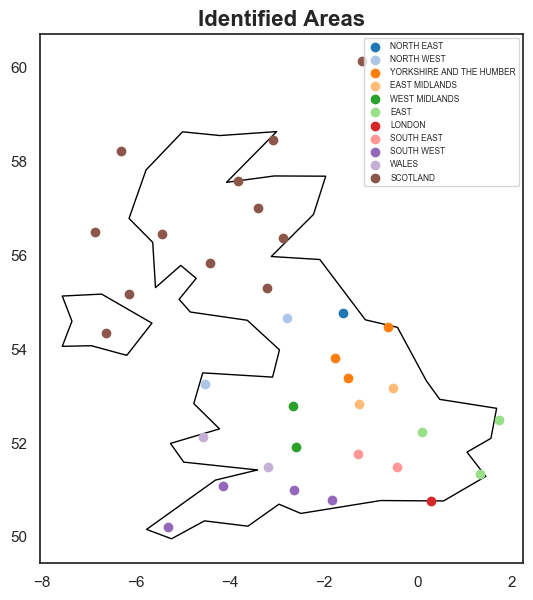

In [72]:
# Plot a map with the identified area names and the sations belonging to them
_, _ax = plt.subplots(figsize=(7,7), dpi=100)
sns.set_style("white")
plotSingleMap(stations_with_loc, cluster_labels=label_names, ax=_ax)
_ = _ax.set_title("Identified Areas", fontsize=16, fontweight="bold")
_ = _ax.legend(fontsize=6)

In [73]:
# Create an aggregated table that represents the weather variations of each area based on the stations
# weather measurments in that area.
aggregation_dict={"tmax":np.max, "tmin":np.min, "af":np.mean, "rain": np.mean, "sun":np.mean}
aggregation_columns = ["area_name", 'tmax', 'tmin', 'af', 'rain', 'sun']

# Copy the table for later use
stations_with_loc_cp = stations_with_loc.copy()

# Aggregate the data
stations_with_loc = stations_with_loc[aggregation_columns].groupby(["area_name"], as_index=True).agg(aggregation_dict)

In [74]:
# Fill the NaN value with the average of the columns
stations_with_loc.sun.fillna(stations_with_loc.sun.mean(), axis=0, inplace=True)

In [75]:
# Merge aggregated weather data with happiness data
weather_and_happiness_df = stations_with_loc.merge(wellbeing_dataset_df, on="area_name")
weather_and_happiness_df.head()

area_name  tmax  tmin        af       rain         sun    low  \
0           EAST  24.4   1.2  2.142857  49.819048  150.760714   8.53   
1  EAST MIDLANDS  24.1   1.1  2.678571  45.682143  132.285714   8.66   
2         LONDON  22.3   2.2  1.000000  68.328571  165.264286   8.32   
3     NORTH EAST  21.8   1.0  3.214286  47.757143  141.682113  10.77   
4    NORTH WEST   21.4   0.1  2.678571  70.878571  152.471429  10.17   

      medium       high   veryhigh  average        lat  lon  
0  15.690000  41.689999  34.090000     7.51  52.200001  0.4  
1  16.740000  38.619999  35.990002     7.51  53.000000 -0.8  
2  18.299999  42.200001  31.180000     7.38  51.500000 -0.1  
3  17.049999  39.060001  33.130001     7.34  55.000000 -1.9  
4  16.820000  39.099998  33.910000     7.39  54.000000 -2.6

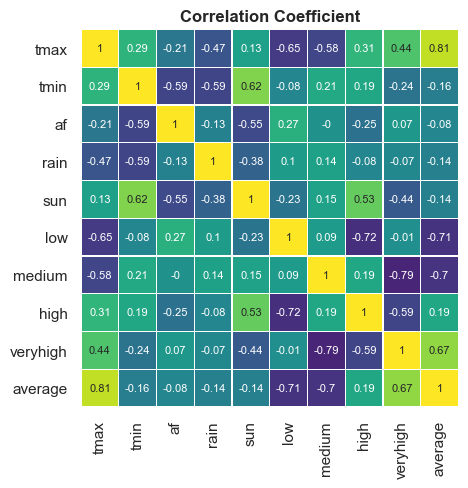

In [76]:
# Create a correlation matrix between the different variables
correlation_matrix = np.round(weather_and_happiness_df.iloc[:, :-2].corr(), 2)

# Plot the correlations
_, _ax = plt.subplots(figsize=(5,5), dpi=100)
sns.heatmap(correlation_matrix, annot=True, annot_kws={"size": 8}, 
                  linewidths=.1, square=True, cbar=False, 
                  center=0, vmin=-1, vmax=1,
                  cmap="viridis", ax=_ax)
_ = _ax.set_title("Correlation Coefficient", fontdict={"fontsize": 12, "fontweight": "bold"})


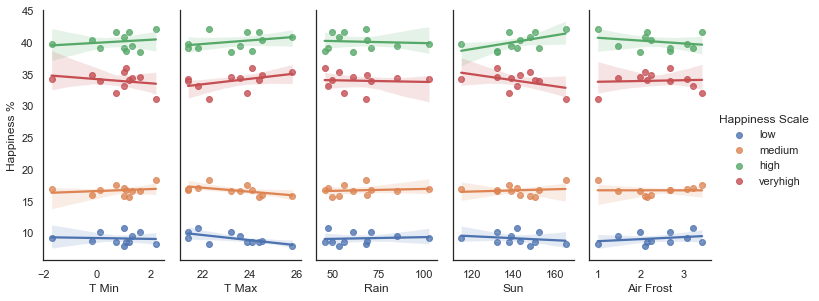

In [77]:
# Plot regression plot for each weather factor and display its correlation
# with happiness

_pair_plot_df = weather_and_happiness_df.iloc[:,:-3].set_index(["area_name", "tmax", "tmin", "af", "rain", "sun"]).stack().reset_index()
_pair_plot_df.columns = ["Area Name", "T Max", "T Min", "Air Frost", "Rain", "Sun", "Happiness Scale", "Happiness %"]

sns.pairplot(x_vars=["T Min", "T Max", "Rain", "Sun", "Air Frost"], y_vars=['Happiness %'],  height=4, aspect=.5,
             kind="reg", diag_kind="hist", hue="Happiness Scale", data=_pair_plot_df);

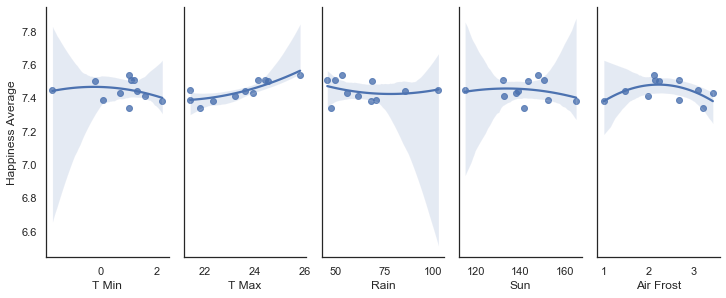

In [78]:
# Plot regression plot for each weather factor and display its correlation
# with the happiness average score
_pair_plot_cols = ["area_name", "tmax", "tmin", "af", "rain", "sun", "average"]
_pair_plot_df = weather_and_happiness_df[_pair_plot_cols]
_pair_plot_df.columns = ["Area Name", "T Max", "T Min", "Air Frost", "Rain", "Sun", "Happiness Average"]

sns.pairplot(x_vars=["T Min", "T Max", "Rain", "Sun", "Air Frost"], y_vars=['Happiness Average'],  height=4, aspect=.5,
             kind="reg", diag_kind="hist", plot_kws={"order": 2}, data=_pair_plot_df);

### Part 3 - A: General Observation
Consdering the above correlation matrix and regression plots, the following can be noted:
- The correlation coefficient between the weather variables (Tmin, Tmax, Air Frost, Sun, Rain) and the happines variables (Low %, Medium %, High %, Very High %, Average) are not high enough to assume the existence of a relationship between them.
- *T max* has a high correlation coefficient with '*Average* Happiness', however, considering the full picture and the other correlation coefficients, this correlation is hard to prove and does not imply direct causation. This relationship can also be the result of a confounding that we don't have enough information to be able to identify.
- Higher values of *T min* seem not to affect the *low* and the *medium* happiness percentages, and the *high* happiness percentage seem to increase very slightly which consequently causes the *very high* percentage to drop. (Since they all sum up to 100%)
- Rain seem not to affect happiness at all
- Airfrost seem to register higher amounts of happiness at its mean compared to its extremes which is also a questionable inference to make.

### Part 3 - B: Linear regression
Before jumping into a final conclusion, we will create a Linear Regression model to try predicting the happiness index (the average happiness) based on the weather values from all the stations in the previously selected time period.

Two models will be created for this purpose, a simple linear model and a polynomial model. 

In [79]:
# Choose the non-aggregated data for regression
weather_and_happiness_regression = stations_with_loc_cp.merge(wellbeing_dataset_df, on="area_name")
weather_and_happiness_regression.fillna(weather_and_happiness_regression.mean(), inplace=True)

In [80]:
# Choose the dependent and independent variables
X = weather_and_happiness_regression[["tmax", "tmin", "af", "rain", "sun"]]
y = weather_and_happiness_regression["average"]

# Create a piplene to streamline fitting with a scaler
pipeline = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))

rmse = []
r2 = []

X_train, X_test, y_train, y_test = None, None, None, None

# Fit the model 10 times with random splits
for i in range(0,10):
    # Split the mode 75/25
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    # Fit the model
    pipeline.fit(X_train, y_train)
    # Predict the test set
    y_pred = pipeline.predict(X_test)
    # Calculate the RMSE and R-squared scores
    rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2.append(r2_score(y_test, y_pred))

Text(0.5, 1.0, 'Residuals Distribution')

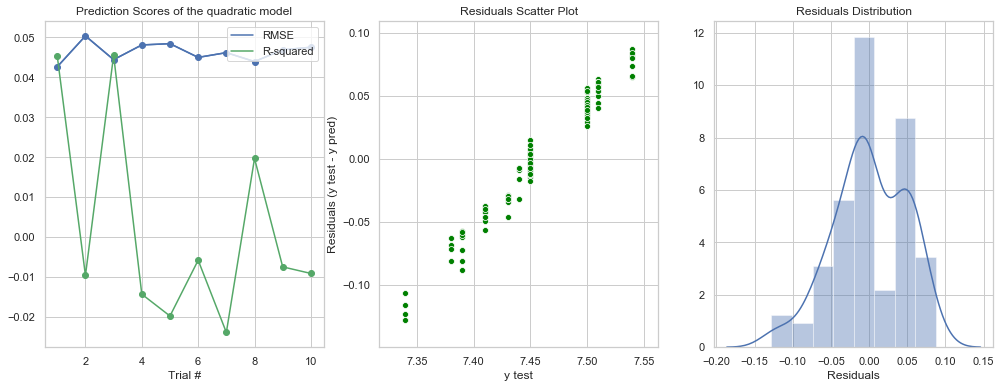

In [81]:
# Residuals are the distance between the predicted value and the fitted value.
residuals = y_test - y_pred

sns.set_style("whitegrid")
plt.figure(figsize=(17,6))

# Prediction Scores
ax = plt.subplot(1,3,1)
ax.plot(np.arange(1, 11), rmse, "b-", label=f"RMSE")
ax.plot(np.arange(1, 11), rmse, "b-o")
ax.plot(np.arange(1, 11), r2, "g-", label=f"R-squared")
ax.plot(np.arange(1, 11), r2, "go")
ax.set_title(f"Prediction Scores of the quadratic model")
ax.set_xlabel("Trial #")
ax.legend(loc='upper right')

# Residuals Scatter
ax = plt.subplot(1,3,2)
sns.scatterplot(x=y_test, y=residuals, ax=ax, color="green")
ax.set_ylabel("Residuals (y test - y pred)")
ax.set_xlabel("y test")
ax.set_title("Residuals Scatter Plot")
ax = plt.subplot(1,3,3)

# Residuals Distribution
_ = sns.distplot(residuals)
ax.set_xlabel("Residuals")
ax.set_title("Residuals Distribution")

The **Root Mean Square Error (RMSE)** is relatively high (approx. 0.5) which means that residuals are widely spread around the regression line. Then the **residuals plot** shows a very clear linear pattern of the residuals, meaning that our model is consistently under and over-predicting the data. It also explains the wide spread or high variance of standard deviation od the residual around zero (between -0.1 and +0.1). The residuals are another indicator of the badness of fit of our model. Finally, if we look at the **R-squared** value, they range from below zero to around 0.025. This indicates that the relationship between our model and the dependent variable (average happiness) is very weak and that the model is a bad predictor of happiness.

In order to conclude if weather can be used as a predictor or indicator of happiness or not, we need to validate that we cannot fit a better model that the one we already fitted. Our last attempt will be trying to fit a model of higher order (quadratic, cubic, .. till the decic polynomial model).

The graphs below, show that the higher the degree of polynomial we get to the lower the RMSE becomes, however RMSE alone is not conclusive as the R-Squared remains near zero and the residual plots show visible patterns. So using higher order polynomials in this case is only overfitting a bad model.

**In conclusion**, based on our regression analysis, and considering our little knowledge about the subject matter and the fact that we only have a small number of independent variables to use as predictors, we don't have enough evidence to prove the existence of a direct relationship between regions with particular weather in the UK and a higher or lower levels of happiness for people living in those regions.

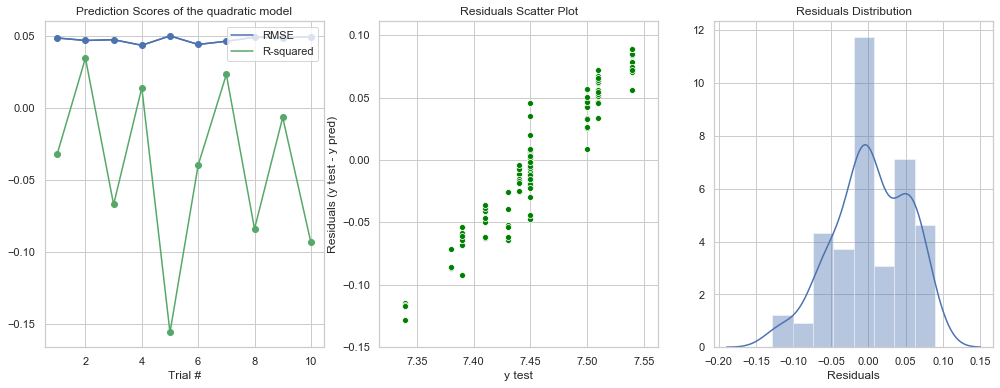

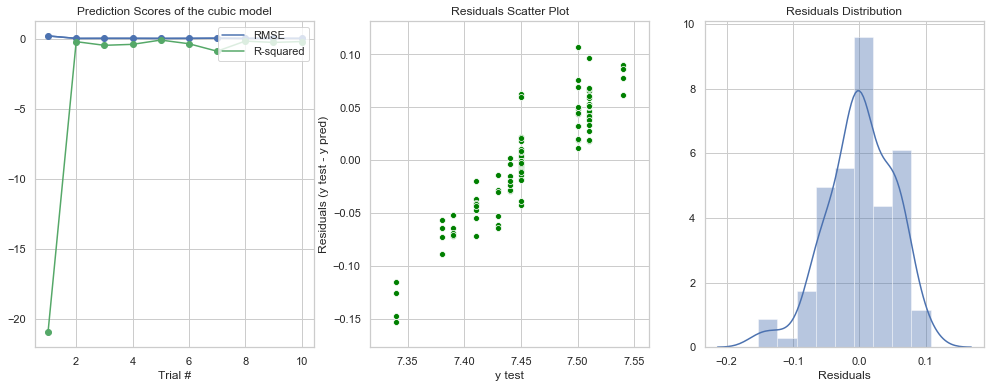

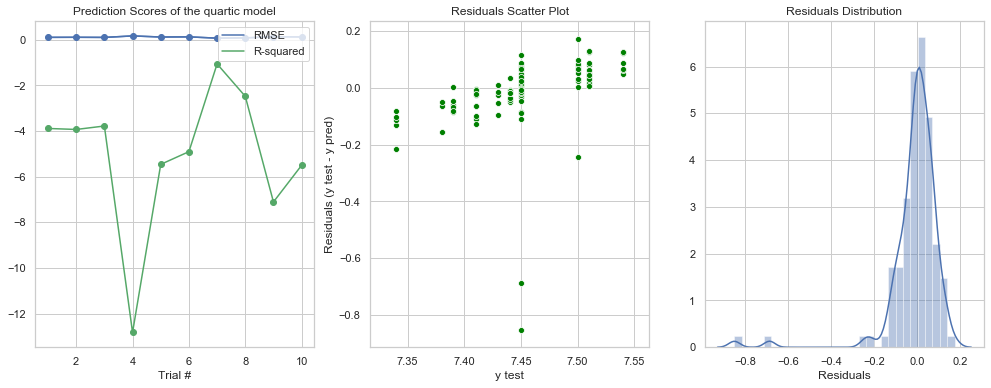

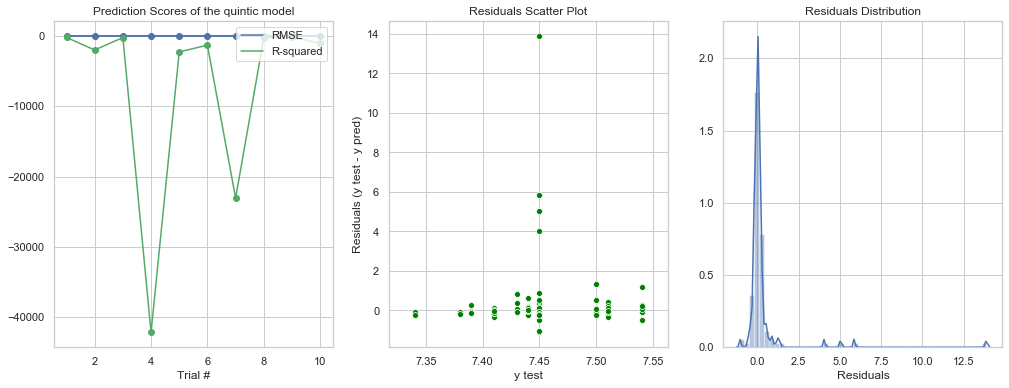

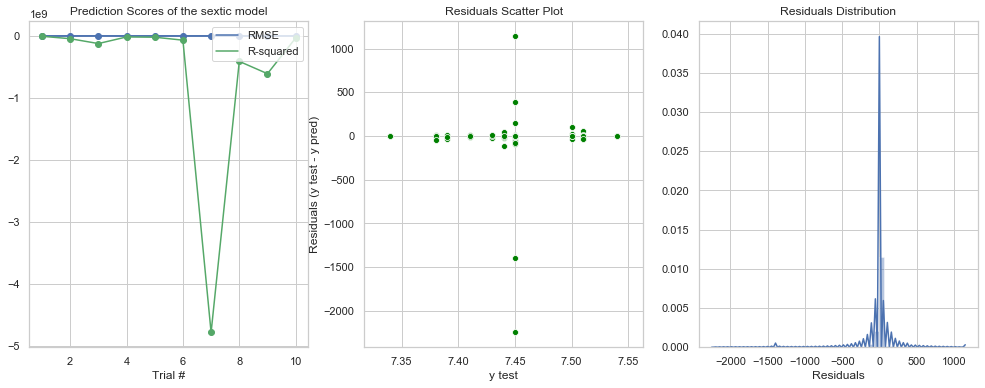

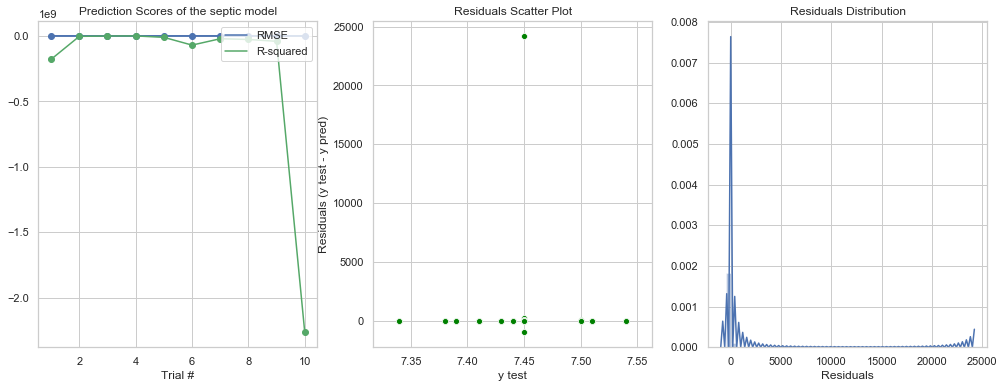

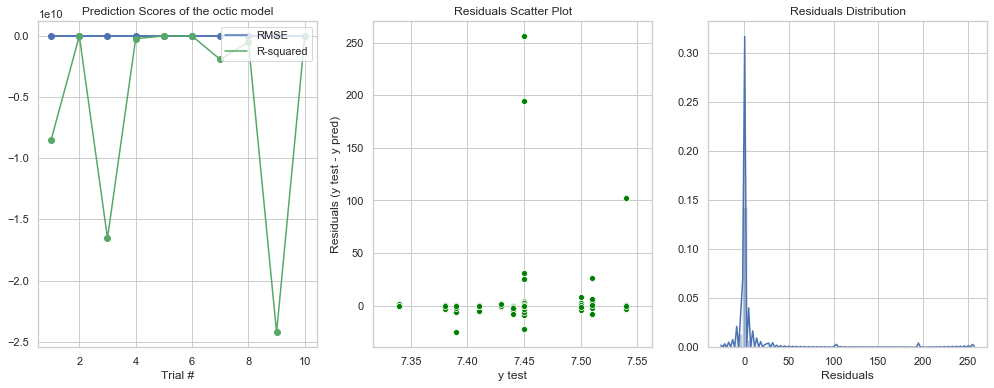

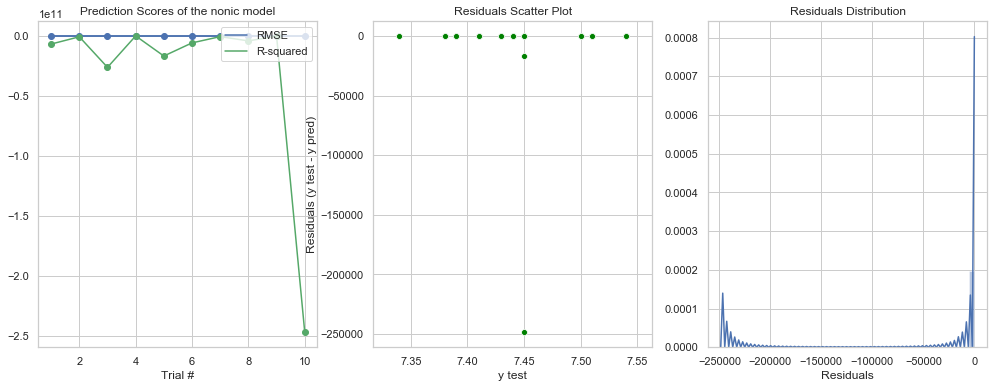

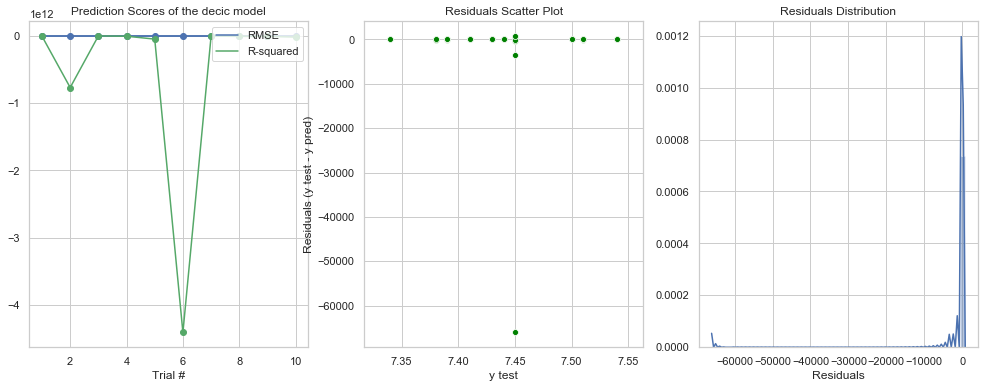

In [82]:
# Ploynomial Models
models = {2: "quadratic", 3: "cubic", 4: "quartic", 5: "quintic", 6: "sextic", 7: "septic", 8: "octic", 9: "nonic", 10: "decic"}

for order, name in models.items():
    # Choose the dependent and independent variables
    X = weather_and_happiness_regression[["tmax", "tmin", "af", "rain", "sun"]]
    y = weather_and_happiness_regression["average"]

    # Create a piplene to streamline fitting with a scaler and a polynomial features transformer
    pipeline = make_pipeline(StandardScaler(), PolynomialFeatures(degree=order), LinearRegression(n_jobs=-1))

    rmse = []
    r2 = []

    X_train, X_test, y_train, y_test = None, None, None, None

    # Fit the model 10 times with random splits
    for i in range(0,10):
        # Split the mode 75/25
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        # Fit the model
        pipeline.fit(X_train, y_train)
        # Predict the test set
        y_pred = pipeline.predict(X_test)
        # Calculate the RMSE and R-squared scores
        rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        r2.append(r2_score(y_test, y_pred))
    
    # Residuals are the distance between the predicted value and the fitted value.
    residuals = y_test - y_pred

    sns.set_style("whitegrid")
    plt.figure(figsize=(17,6))

    # Prediction Scores
    ax = plt.subplot(1,3,1)
    ax.plot(np.arange(1, 11), rmse, "b-", label=f"RMSE")
    ax.plot(np.arange(1, 11), rmse, "b-o")
    ax.plot(np.arange(1, 11), r2, "g-", label=f"R-squared")
    ax.plot(np.arange(1, 11), r2, "go")
    ax.set_title(f"Prediction Scores of the {name} model")
    ax.set_xlabel("Trial #")
    ax.legend(loc='upper right')

    # Residuals Scatter
    ax = plt.subplot(1,3,2)
    sns.scatterplot(x=y_test, y=residuals, ax=ax, color="green")
    ax.set_ylabel("Residuals (y test - y pred)")
    ax.set_xlabel("y test")
    ax.set_title("Residuals Scatter Plot")
    ax = plt.subplot(1,3,3)

    # Residuals Distribution
    _ = sns.distplot(residuals)
    ax.set_xlabel("Residuals")
    ax.set_title("Residuals Distribution")